In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANATOMÍA PATOLÓGICA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=159.1, y1=102.1
Page 1, Q1, A: Yellow pixels: 142
Page 1, Q1, A: Total non-white pixels: 623
Page 1, Q1, A: Yellow percentage: 22.8%


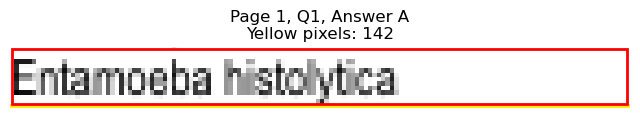

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=156.1, y1=114.7
Page 1, Q1, B: Yellow pixels: 1474
Page 1, Q1, B: Total non-white pixels: 1807
Page 1, Q1, B: Yellow percentage: 81.6%


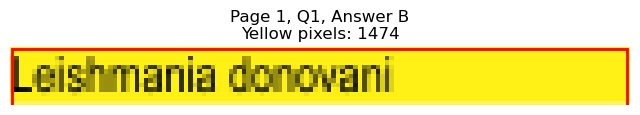

Page 1, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=397.3, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 382
Page 1, Q1, C: Yellow percentage: 0.0%


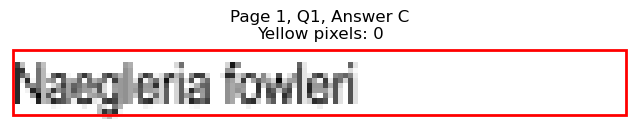

Page 1, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=406.7, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 382
Page 1, Q1, D: Yellow percentage: 0.0%


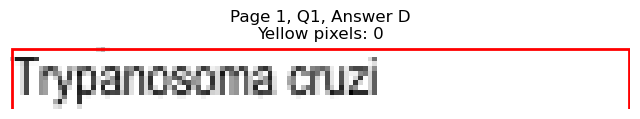


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=181.7, y1=177.8
Page 1, Q2, A: Yellow pixels: 1
Page 1, Q2, A: Total non-white pixels: 704
Page 1, Q2, A: Yellow percentage: 0.1%


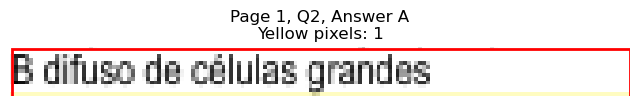

Page 1, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=104.9, y1=190.4
Page 1, Q2, B: Yellow pixels: 918
Page 1, Q2, B: Total non-white pixels: 1218
Page 1, Q2, B: Yellow percentage: 75.4%


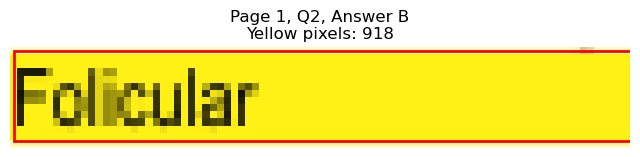

Page 1, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=408.3, y1=177.8
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 389
Page 1, Q2, C: Yellow percentage: 0.0%


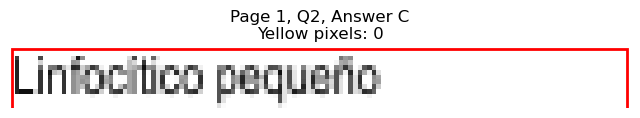

Page 1, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=369.7, y1=190.4
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 202
Page 1, Q2, D: Yellow percentage: 0.0%


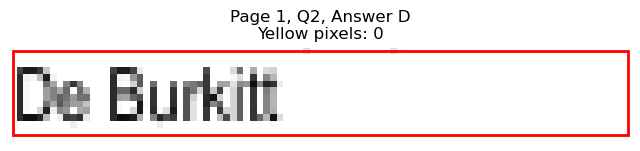


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=133.0, y1=253.5
Page 1, Q3, A: Yellow pixels: 1221
Page 1, Q3, A: Total non-white pixels: 1610
Page 1, Q3, A: Yellow percentage: 75.8%


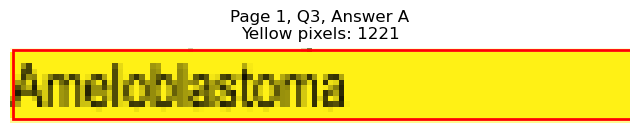

Page 1, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=161.5, y1=266.1
Page 1, Q3, B: Yellow pixels: 144
Page 1, Q3, B: Total non-white pixels: 605
Page 1, Q3, B: Yellow percentage: 23.8%


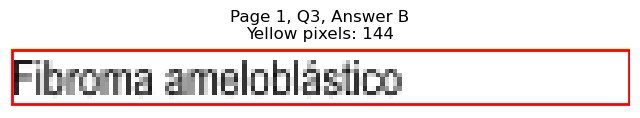

Page 1, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=448.4, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 620
Page 1, Q3, C: Yellow percentage: 0.0%


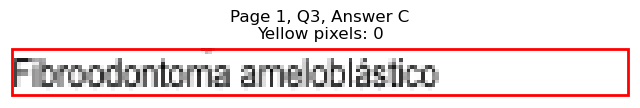

Page 1, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=466.0, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 684
Page 1, Q3, D: Yellow percentage: 0.0%


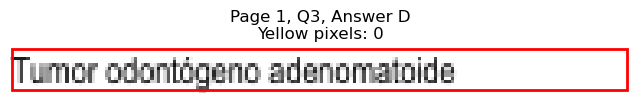


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=126.5, y1=304.1
Page 1, Q4, A: Yellow pixels: 1176
Page 1, Q4, A: Total non-white pixels: 1526
Page 1, Q4, A: Yellow percentage: 77.1%


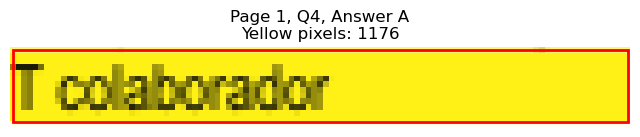

Page 1, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=116.4, y1=316.7
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 332
Page 1, Q4, B: Yellow percentage: 0.0%


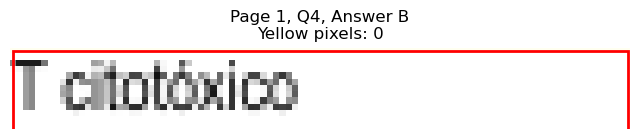

Page 1, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=373.6, y1=304.1
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 217
Page 1, Q4, C: Yellow percentage: 0.0%


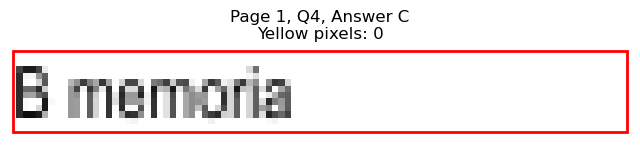

Page 1, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=363.2, y1=316.7
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 161
Page 1, Q4, D: Yellow percentage: 0.0%


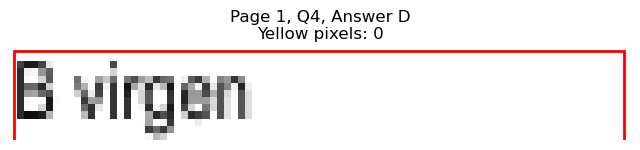


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=151.1, y1=354.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 395
Page 1, Q5, A: Yellow percentage: 0.0%


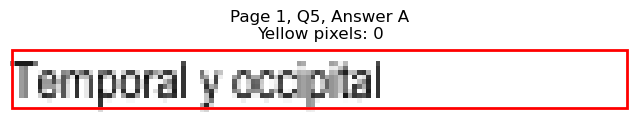

Page 1, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=143.5, y1=367.2
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 389
Page 1, Q5, B: Yellow percentage: 0.0%


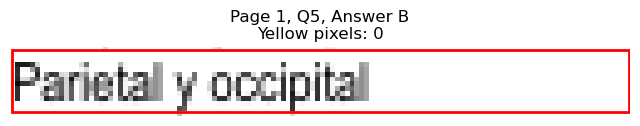

Page 1, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=400.3, y1=354.6
Page 1, Q5, C: Yellow pixels: 124
Page 1, Q5, C: Total non-white pixels: 482
Page 1, Q5, C: Yellow percentage: 25.7%


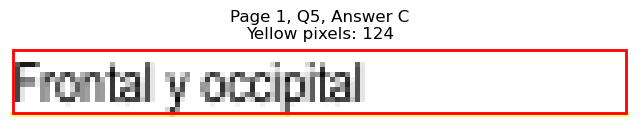

Page 1, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=405.3, y1=367.2
Page 1, Q5, D: Yellow pixels: 1385
Page 1, Q5, D: Total non-white pixels: 1806
Page 1, Q5, D: Yellow percentage: 76.7%


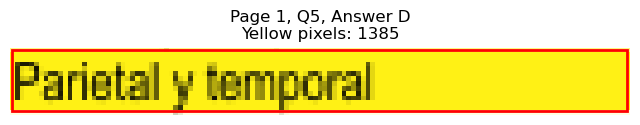


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=189.1, y1=430.3
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 615
Page 1, Q6, A: Yellow percentage: 0.0%


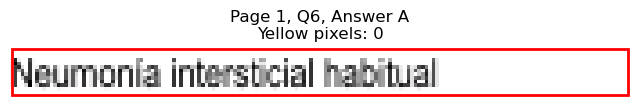

Page 1, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=117.5, y1=442.9
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 259
Page 1, Q6, B: Yellow percentage: 0.0%


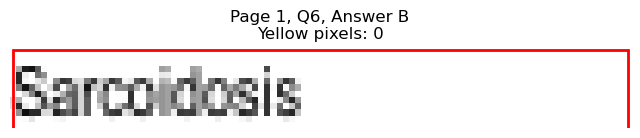

Page 1, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=482.6, y1=430.3
Page 1, Q6, C: Yellow pixels: 1849
Page 1, Q6, C: Total non-white pixels: 2884
Page 1, Q6, C: Yellow percentage: 64.1%


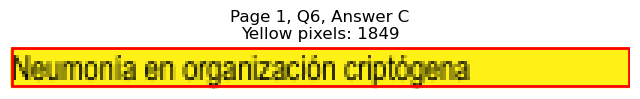

Page 1, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=448.9, y1=442.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 790
Page 1, Q6, D: Yellow percentage: 0.0%


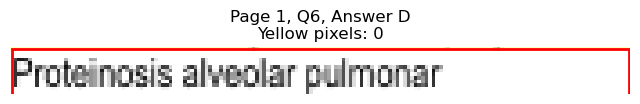


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=144.5, y1=506.0
Page 1, Q7, A: Yellow pixels: 1366
Page 1, Q7, A: Total non-white pixels: 1651
Page 1, Q7, A: Yellow percentage: 82.7%


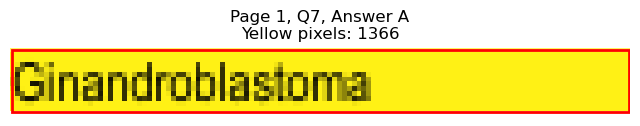

Page 1, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=210.3, y1=518.6
Page 1, Q7, B: Yellow pixels: 193
Page 1, Q7, B: Total non-white pixels: 912
Page 1, Q7, B: Yellow percentage: 21.2%


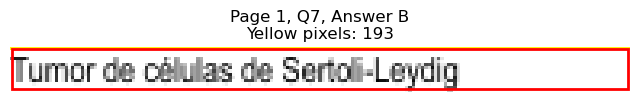

Page 1, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=463.4, y1=506.0
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 661
Page 1, Q7, C: Yellow percentage: 0.0%


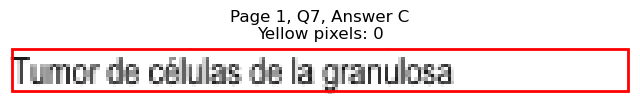

Page 1, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=448.9, y1=518.6
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 605
Page 1, Q7, D: Yellow percentage: 0.0%


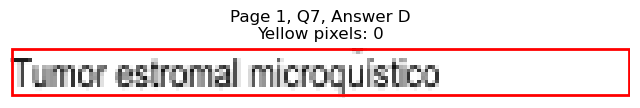


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=148.6, y1=594.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 399
Page 1, Q8, A: Yellow percentage: 0.0%


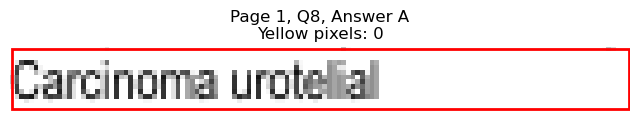

Page 1, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=245.8, y1=607.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 888
Page 1, Q8, B: Yellow percentage: 0.0%


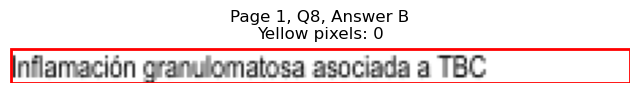

Page 1, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=410.8, y1=594.4
Page 1, Q8, C: Yellow pixels: 134
Page 1, Q8, C: Total non-white pixels: 562
Page 1, Q8, C: Yellow percentage: 23.8%


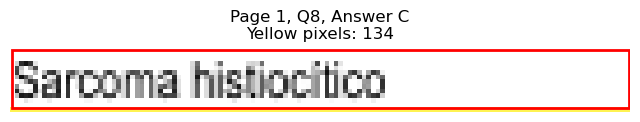

Page 1, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=388.3, y1=607.0
Page 1, Q8, D: Yellow pixels: 1207
Page 1, Q8, D: Total non-white pixels: 1456
Page 1, Q8, D: Yellow percentage: 82.9%


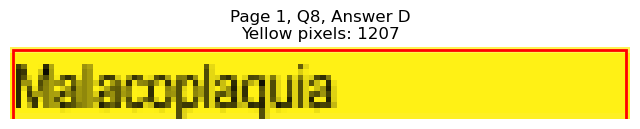


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=221.8, y1=644.9
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 754
Page 1, Q9, A: Yellow percentage: 0.0%


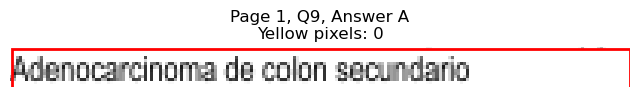

Page 1, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=183.6, y1=657.5
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 549
Page 1, Q9, B: Yellow percentage: 0.0%


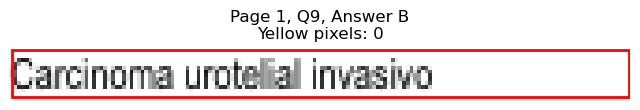

Page 1, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=471.6, y1=644.9
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 912
Page 1, Q9, C: Yellow percentage: 0.0%


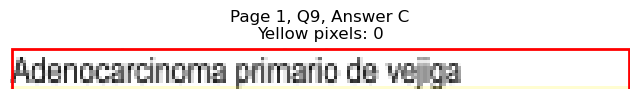

Page 1, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=424.9, y1=657.5
Page 1, Q9, D: Yellow pixels: 1572
Page 1, Q9, D: Total non-white pixels: 2072
Page 1, Q9, D: Yellow percentage: 75.9%


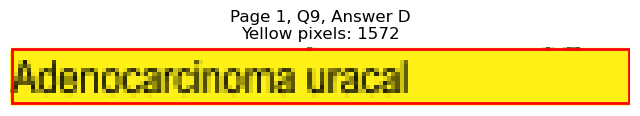


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=174.1, y1=708.0
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 478
Page 1, Q10, A: Yellow percentage: 0.0%


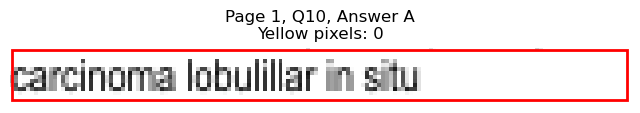

Page 1, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=170.2, y1=720.6
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 526
Page 1, Q10, B: Yellow percentage: 0.0%


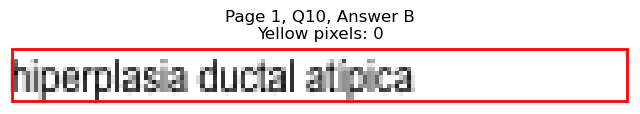

Page 1, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=458.5, y1=708.0
Page 1, Q10, C: Yellow pixels: 1842
Page 1, Q10, C: Total non-white pixels: 2369
Page 1, Q10, C: Yellow percentage: 77.8%


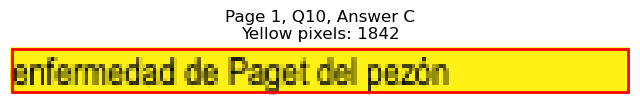

Page 1, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=410.8, y1=720.6
Page 1, Q10, D: Yellow pixels: 129
Page 1, Q10, D: Total non-white pixels: 574
Page 1, Q10, D: Yellow percentage: 22.5%


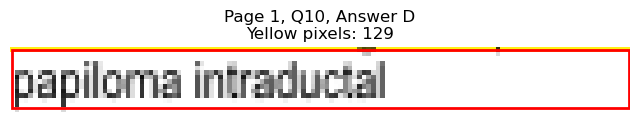


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=87.9, y1=758.4
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 93
Page 1, Q11, A: Yellow percentage: 0.0%


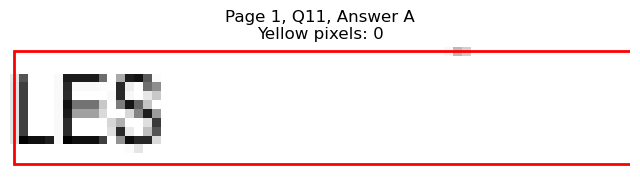

Page 1, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=147.5, y1=771.2
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 401
Page 1, Q11, B: Yellow percentage: 0.0%


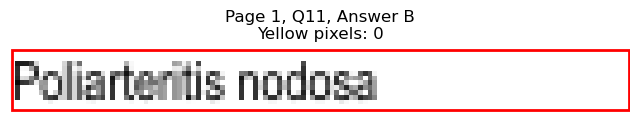

Page 1, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=418.9, y1=758.4
Page 1, Q11, C: Yellow pixels: 0
Page 1, Q11, C: Total non-white pixels: 451
Page 1, Q11, C: Yellow percentage: 0.0%


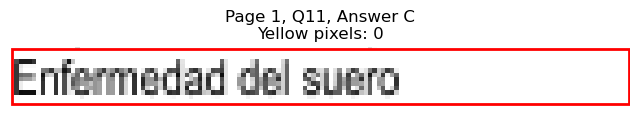

Page 1, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=417.4, y1=771.2
Page 1, Q11, D: Yellow pixels: 1471
Page 1, Q11, D: Total non-white pixels: 1974
Page 1, Q11, D: Yellow percentage: 74.5%


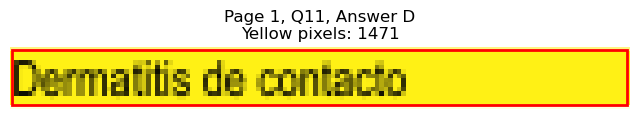


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=144.0, y1=139.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 384
Page 2, Q1, A: Yellow percentage: 0.0%


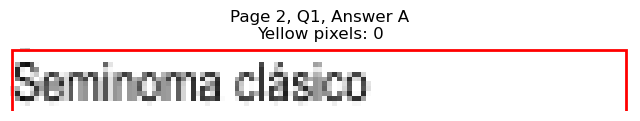

Page 2, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=163.1, y1=152.6
Page 2, Q1, B: Yellow pixels: 1543
Page 2, Q1, B: Total non-white pixels: 2044
Page 2, Q1, B: Yellow percentage: 75.5%


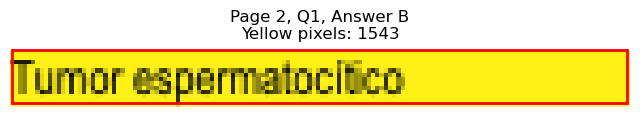

Page 2, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=440.9, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 549
Page 2, Q1, C: Yellow percentage: 0.0%


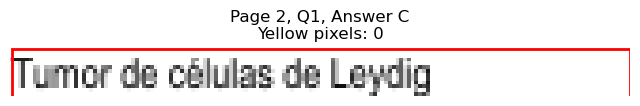

Page 2, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=410.8, y1=152.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 405
Page 2, Q1, D: Yellow percentage: 0.0%


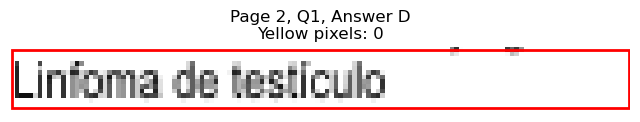


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=152.5, y1=215.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 447
Page 2, Q2, A: Yellow percentage: 0.0%


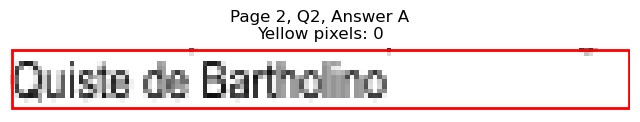

Page 2, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=142.6, y1=228.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 363
Page 2, Q2, B: Yellow percentage: 0.0%


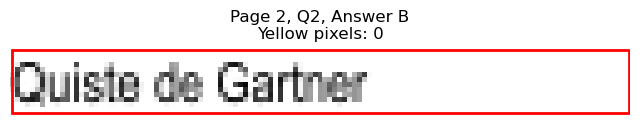

Page 2, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=413.8, y1=215.6
Page 2, Q2, C: Yellow pixels: 1400
Page 2, Q2, C: Total non-white pixels: 1918
Page 2, Q2, C: Yellow percentage: 73.0%


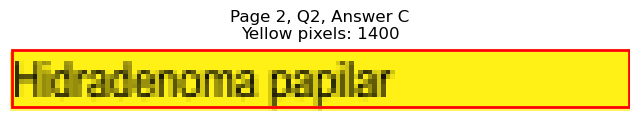

Page 2, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=475.5, y1=228.3
Page 2, Q2, D: Yellow pixels: 199
Page 2, Q2, D: Total non-white pixels: 957
Page 2, Q2, D: Yellow percentage: 20.8%


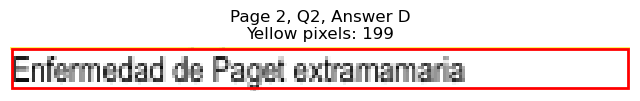


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=189.1, y1=291.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 645
Page 2, Q3, A: Yellow percentage: 0.0%


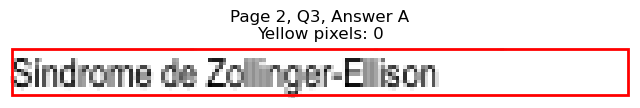

Page 2, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=137.5, y1=304.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 371
Page 2, Q3, B: Yellow percentage: 0.0%


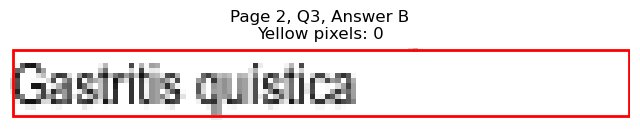

Page 2, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=432.3, y1=291.5
Page 2, Q3, C: Yellow pixels: 1590
Page 2, Q3, C: Total non-white pixels: 2184
Page 2, Q3, C: Yellow percentage: 72.8%


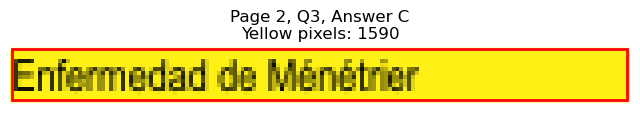

Page 2, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=449.5, y1=304.1
Page 2, Q3, D: Yellow pixels: 173
Page 2, Q3, D: Total non-white pixels: 812
Page 2, Q3, D: Yellow percentage: 21.3%


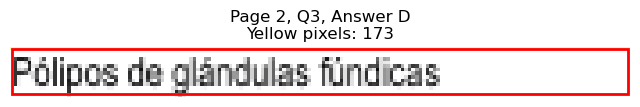


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=215.7, y1=341.9
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 746
Page 2, Q4, A: Yellow percentage: 0.0%


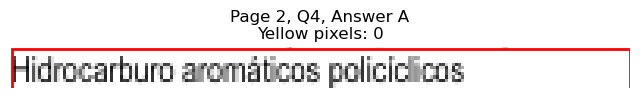

Page 2, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=140.5, y1=354.6
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 367
Page 2, Q4, B: Yellow percentage: 0.0%


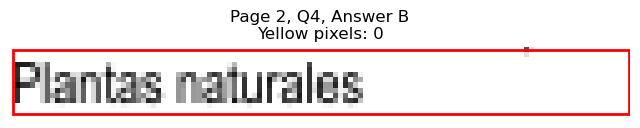

Page 2, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=419.8, y1=341.9
Page 2, Q4, C: Yellow pixels: 1479
Page 2, Q4, C: Total non-white pixels: 1859
Page 2, Q4, C: Yellow percentage: 79.6%


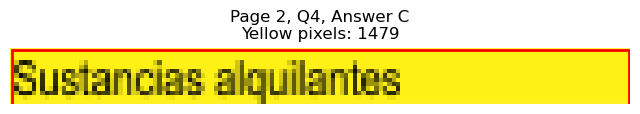

Page 2, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=421.9, y1=354.6
Page 2, Q4, D: Yellow pixels: 143
Page 2, Q4, D: Total non-white pixels: 594
Page 2, Q4, D: Yellow percentage: 24.1%


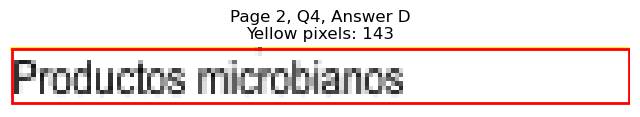


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=160.6, y1=392.4
Page 2, Q5, A: Yellow pixels: 143
Page 2, Q5, A: Total non-white pixels: 585
Page 2, Q5, A: Yellow percentage: 24.4%


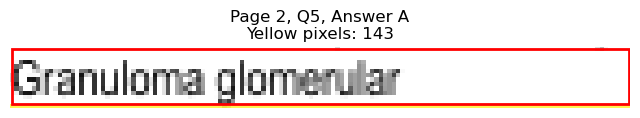

Page 2, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=207.6, y1=405.0
Page 2, Q5, B: Yellow pixels: 1892
Page 2, Q5, B: Total non-white pixels: 2470
Page 2, Q5, B: Yellow percentage: 76.6%


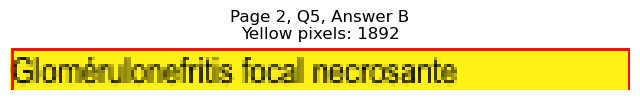

Page 2, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=411.8, y1=392.4
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 441
Page 2, Q5, C: Yellow percentage: 0.0%


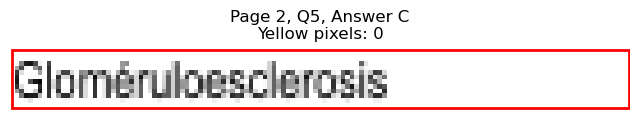

Page 2, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=417.3, y1=405.0
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 471
Page 2, Q5, D: Yellow percentage: 0.0%


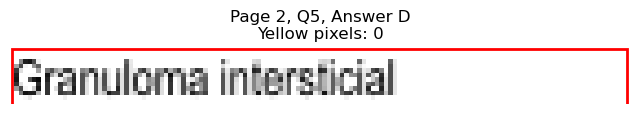


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=280.0, y1=506.0
Page 2, Q6, A: Yellow pixels: 213
Page 2, Q6, A: Total non-white pixels: 1565
Page 2, Q6, A: Yellow percentage: 13.6%


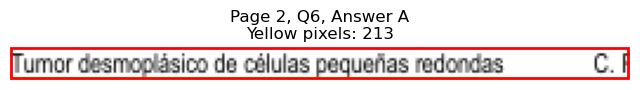

Page 2, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=217.7, y1=518.6
Page 2, Q6, B: Yellow pixels: 2008
Page 2, Q6, B: Total non-white pixels: 2800
Page 2, Q6, B: Yellow percentage: 71.7%


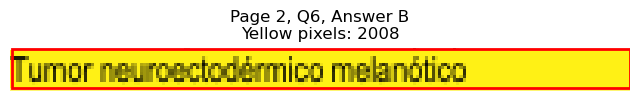

Page 2, Q6 - C: Detected box: x0=327.5, y0=493.4, x1=455.9, y1=506.0
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 652
Page 2, Q6, C: Yellow percentage: 0.0%


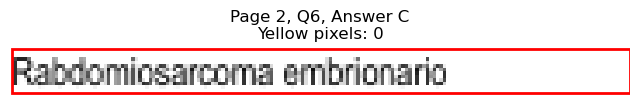

Page 2, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=422.8, y1=518.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 509
Page 2, Q6, D: Yellow percentage: 0.0%


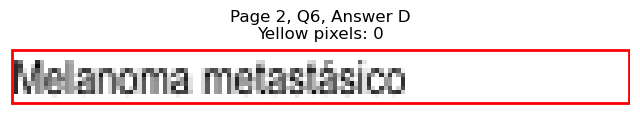


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=107.4, y1=581.8
Page 2, Q7, A: Yellow pixels: 1013
Page 2, Q7, A: Total non-white pixels: 1170
Page 2, Q7, A: Yellow percentage: 86.6%


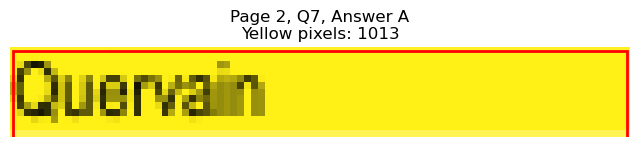

Page 2, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=96.4, y1=594.4
Page 2, Q7, B: Yellow pixels: 79
Page 2, Q7, B: Total non-white pixels: 235
Page 2, Q7, B: Yellow percentage: 33.6%


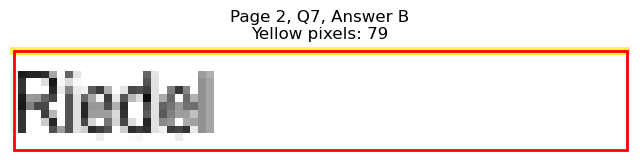

Page 2, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=373.1, y1=581.8
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 218
Page 2, Q7, C: Yellow percentage: 0.0%


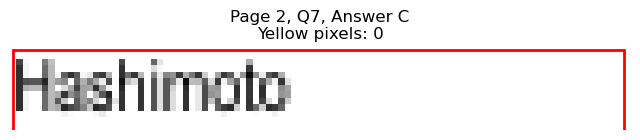

Page 2, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=412.9, y1=594.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 420
Page 2, Q7, D: Yellow percentage: 0.0%


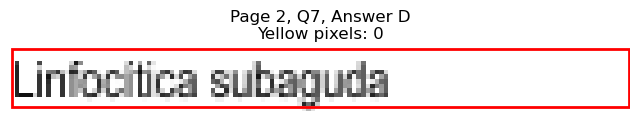


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=142.6, y1=644.9
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 500
Page 2, Q8, A: Yellow percentage: 0.0%


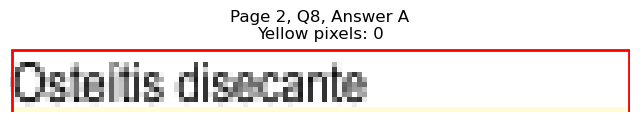

Page 2, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=122.4, y1=657.5
Page 2, Q8, B: Yellow pixels: 1166
Page 2, Q8, B: Total non-white pixels: 1470
Page 2, Q8, B: Yellow percentage: 79.3%


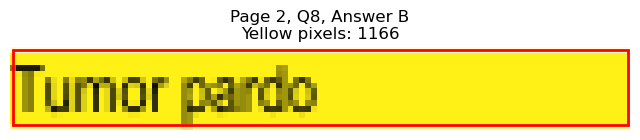

Page 2, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=383.2, y1=644.9
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 279
Page 2, Q8, C: Yellow percentage: 0.0%


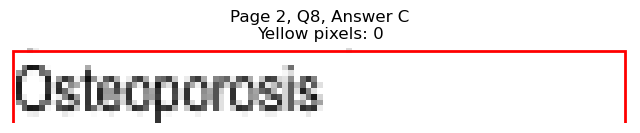

Page 2, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=423.9, y1=657.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 482
Page 2, Q8, D: Yellow percentage: 0.0%


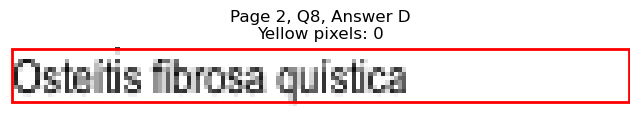


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=165.6, y1=720.6
Page 2, Q9, A: Yellow pixels: 1515
Page 2, Q9, A: Total non-white pixels: 2072
Page 2, Q9, A: Yellow percentage: 73.1%


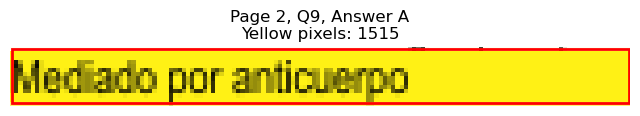

Page 2, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=117.5, y1=733.2
Page 2, Q9, B: Yellow pixels: 100
Page 2, Q9, B: Total non-white pixels: 379
Page 2, Q9, B: Yellow percentage: 26.4%


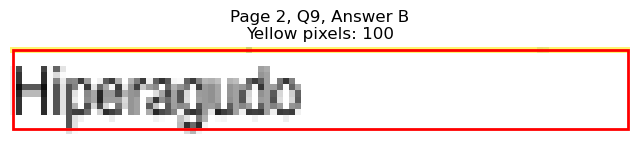

Page 2, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=361.1, y1=720.6
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 164
Page 2, Q9, C: Yellow percentage: 0.0%


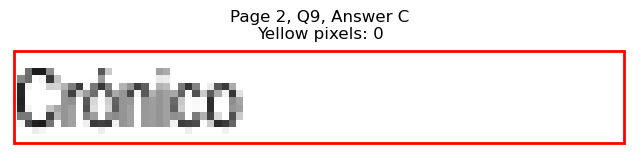

Page 2, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=402.8, y1=733.2
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 399
Page 2, Q9, D: Yellow percentage: 0.0%


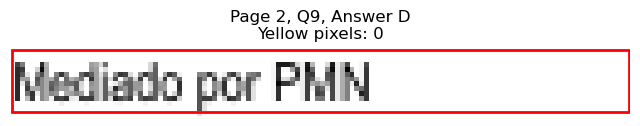


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=119.4, y1=102.1
Page 3, Q1, A: Yellow pixels: 102
Page 3, Q1, A: Total non-white pixels: 333
Page 3, Q1, A: Yellow percentage: 30.6%


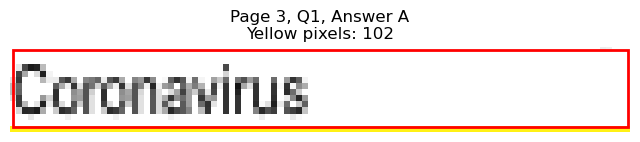

Page 3, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=128.4, y1=114.7
Page 3, Q1, B: Yellow pixels: 1199
Page 3, Q1, B: Total non-white pixels: 1443
Page 3, Q1, B: Yellow percentage: 83.1%


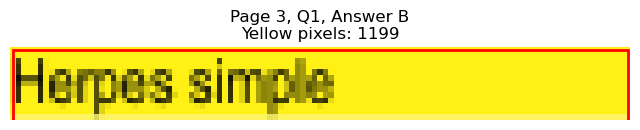

Page 3, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=356.1, y1=102.1
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 132
Page 3, Q1, C: Yellow percentage: 0.0%


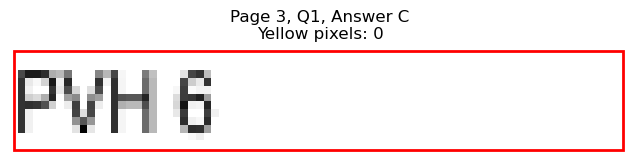

Page 3, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=361.1, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 121
Page 3, Q1, D: Yellow percentage: 0.0%


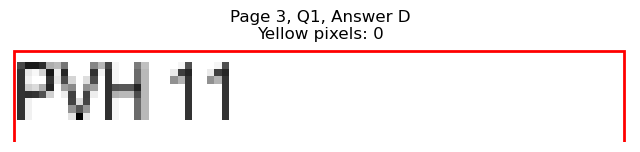


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=83.3, y1=152.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 66
Page 3, Q2, A: Yellow percentage: 0.0%


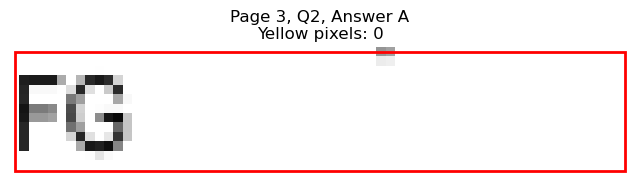

Page 3, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=89.4, y1=165.2
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 94
Page 3, Q2, B: Yellow percentage: 0.0%


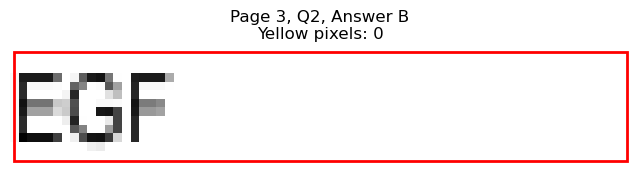

Page 3, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=355.1, y1=152.6
Page 3, Q2, C: Yellow pixels: 79
Page 3, Q2, C: Total non-white pixels: 218
Page 3, Q2, C: Yellow percentage: 36.2%


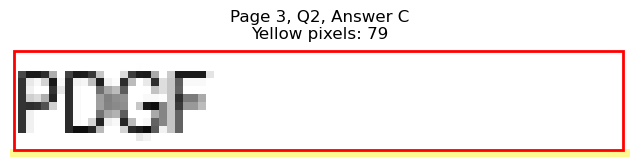

Page 3, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=356.6, y1=165.2
Page 3, Q2, D: Yellow pixels: 936
Page 3, Q2, D: Total non-white pixels: 1120
Page 3, Q2, D: Yellow percentage: 83.6%


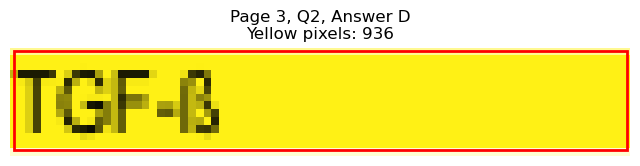


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=138.0, y1=228.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 373
Page 3, Q3, A: Yellow percentage: 0.0%


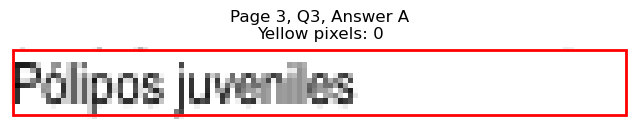

Page 3, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=155.5, y1=240.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 448
Page 3, Q3, B: Yellow percentage: 0.0%


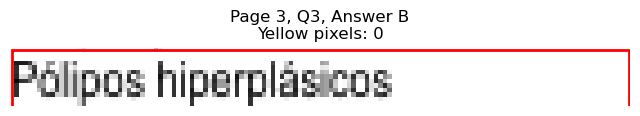

Page 3, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=441.9, y1=228.3
Page 3, Q3, C: Yellow pixels: 1562
Page 3, Q3, C: Total non-white pixels: 2310
Page 3, Q3, C: Yellow percentage: 67.6%


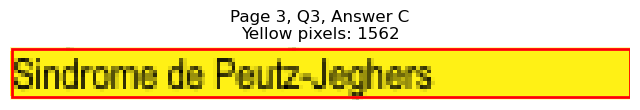

Page 3, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=417.3, y1=240.9
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 589
Page 3, Q3, D: Yellow percentage: 0.0%


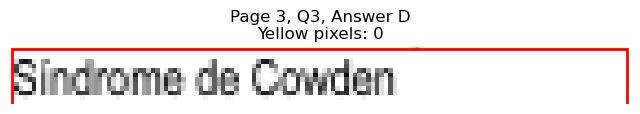


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=219.3, y1=278.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 722
Page 3, Q4, A: Yellow percentage: 0.0%


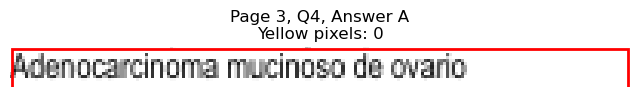

Page 3, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=172.6, y1=291.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 521
Page 3, Q4, B: Yellow percentage: 0.0%


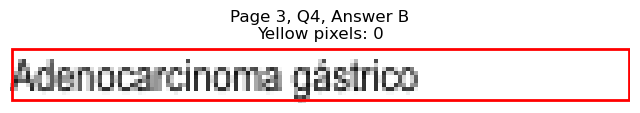

Page 3, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=448.9, y1=278.7
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 602
Page 3, Q4, C: Yellow percentage: 0.0%


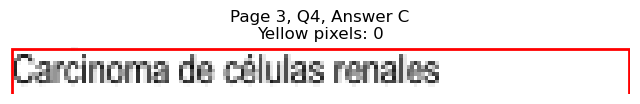

Page 3, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=372.2, y1=291.5
Page 3, Q4, D: Yellow pixels: 1057
Page 3, Q4, D: Total non-white pixels: 1344
Page 3, Q4, D: Yellow percentage: 78.6%


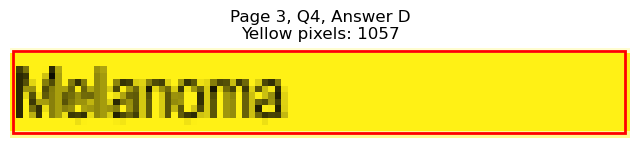


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=175.1, y1=354.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 548
Page 3, Q5, A: Yellow percentage: 0.0%


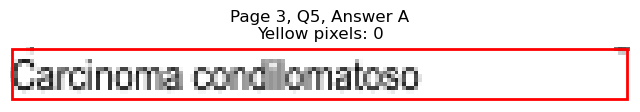

Page 3, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=144.0, y1=367.2
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 347
Page 3, Q5, B: Yellow percentage: 0.0%


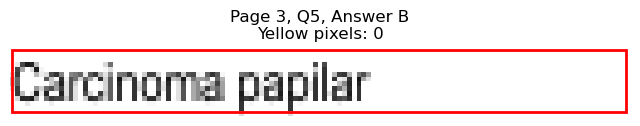

Page 3, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=415.7, y1=354.6
Page 3, Q5, C: Yellow pixels: 1478
Page 3, Q5, C: Total non-white pixels: 1946
Page 3, Q5, C: Yellow percentage: 76.0%


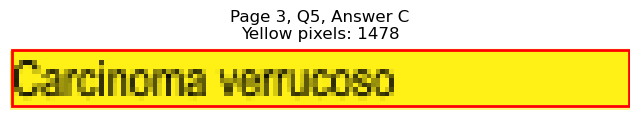

Page 3, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=405.3, y1=367.2
Page 3, Q5, D: Yellow pixels: 129
Page 3, Q5, D: Total non-white pixels: 552
Page 3, Q5, D: Yellow percentage: 23.4%


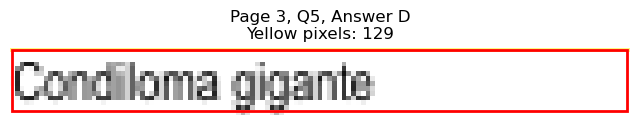


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=210.3, y1=442.9
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 717
Page 3, Q6, A: Yellow percentage: 0.0%


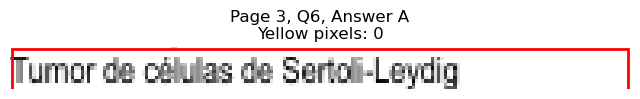

Page 3, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=204.2, y1=455.5
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 681
Page 3, Q6, B: Yellow percentage: 0.0%


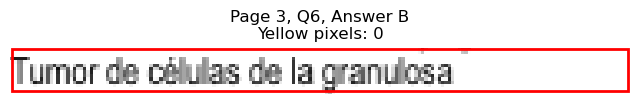

Page 3, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=380.2, y1=442.9
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 370
Page 3, Q6, C: Yellow percentage: 0.0%


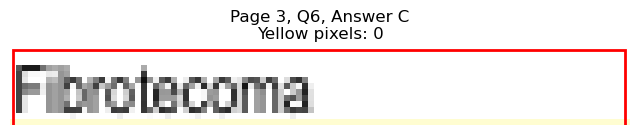

Page 3, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=403.3, y1=455.5
Page 3, Q6, D: Yellow pixels: 1371
Page 3, Q6, D: Total non-white pixels: 1778
Page 3, Q6, D: Yellow percentage: 77.1%


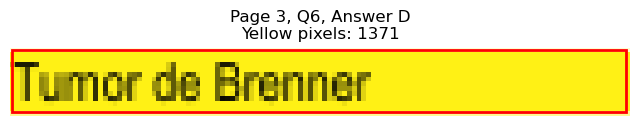


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=113.9, y1=518.6
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 244
Page 3, Q7, A: Yellow percentage: 0.0%


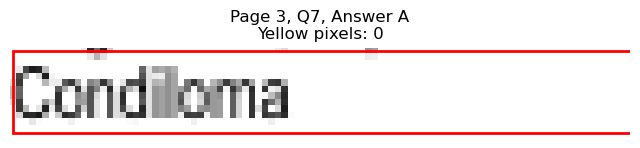

Page 3, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=156.0, y1=531.2
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 448
Page 3, Q7, B: Yellow percentage: 0.0%


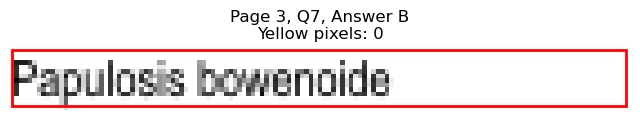

Page 3, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=388.3, y1=518.6
Page 3, Q7, C: Yellow pixels: 112
Page 3, Q7, C: Total non-white pixels: 440
Page 3, Q7, C: Yellow percentage: 25.5%


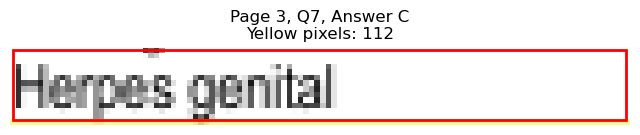

Page 3, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=409.9, y1=531.2
Page 3, Q7, D: Yellow pixels: 1405
Page 3, Q7, D: Total non-white pixels: 1862
Page 3, Q7, D: Yellow percentage: 75.5%


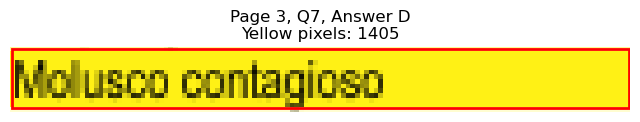


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=118.5, y1=594.4
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 265
Page 3, Q8, A: Yellow percentage: 0.0%


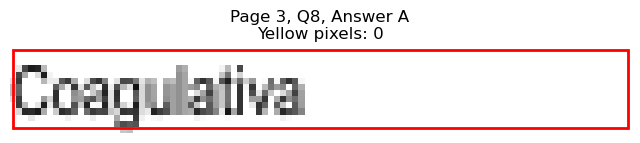

Page 3, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=95.4, y1=607.0
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 136
Page 3, Q8, B: Yellow percentage: 0.0%


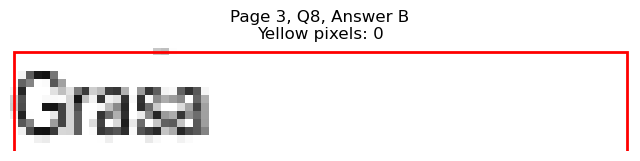

Page 3, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=365.7, y1=594.4
Page 3, Q8, C: Yellow pixels: 924
Page 3, Q8, C: Total non-white pixels: 1246
Page 3, Q8, C: Yellow percentage: 74.2%


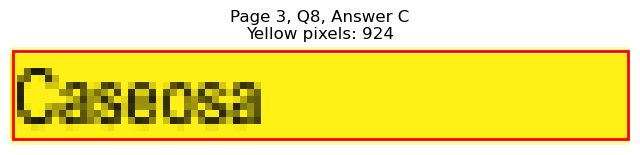

Page 3, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=369.7, y1=607.0
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 322
Page 3, Q8, D: Yellow percentage: 0.0%


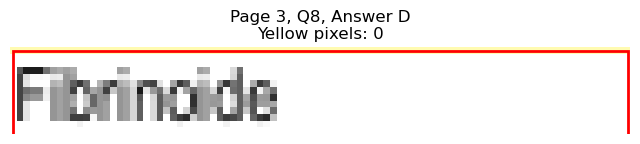


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=118.9, y1=657.5
Page 3, Q9, A: Yellow pixels: 1103
Page 3, Q9, A: Total non-white pixels: 1414
Page 3, Q9, A: Yellow percentage: 78.0%


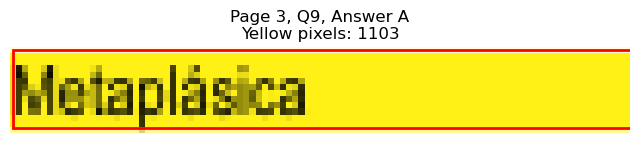

Page 3, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=126.5, y1=670.1
Page 3, Q9, B: Yellow pixels: 109
Page 3, Q9, B: Total non-white pixels: 444
Page 3, Q9, B: Yellow percentage: 24.5%


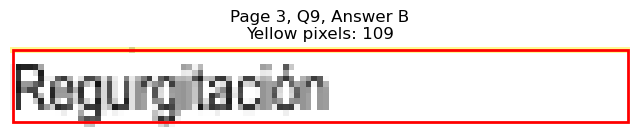

Page 3, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=505.2, y1=657.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 911
Page 3, Q9, C: Yellow percentage: 0.0%


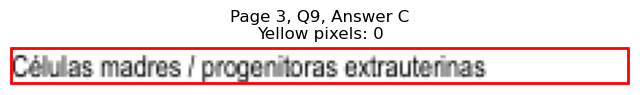

Page 3, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=412.3, y1=670.1
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 469
Page 3, Q9, D: Yellow percentage: 0.0%


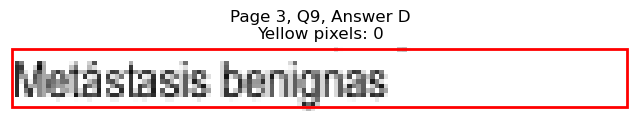


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=65.2, y1=720.6
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 67
Page 3, Q10, A: Yellow percentage: 0.0%


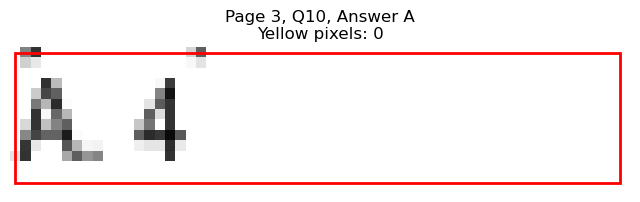

Page 3, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=65.2, y1=733.2
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 69
Page 3, Q10, B: Yellow percentage: 0.0%


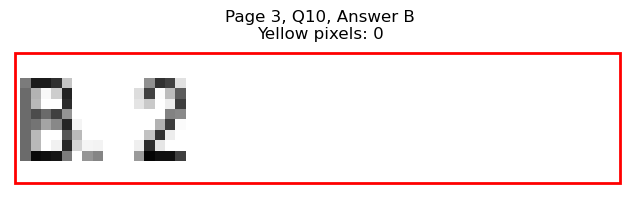

Page 3, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=324.4, y1=720.6
Page 3, Q10, C: Yellow pixels: 60
Page 3, Q10, C: Total non-white pixels: 109
Page 3, Q10, C: Yellow percentage: 55.0%


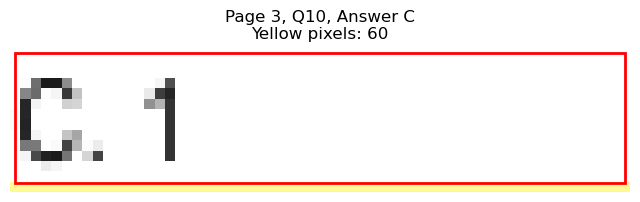

Page 3, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=324.4, y1=733.2
Page 3, Q10, D: Yellow pixels: 731
Page 3, Q10, D: Total non-white pixels: 840
Page 3, Q10, D: Yellow percentage: 87.0%


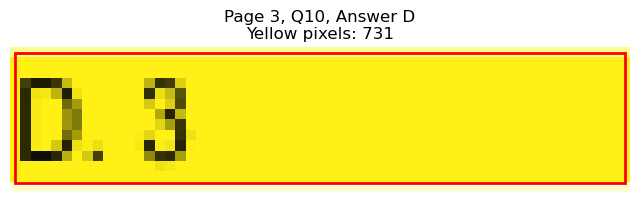


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=76.8, y1=102.1
Page 4, Q1, A: Yellow pixels: 742
Page 4, Q1, A: Total non-white pixels: 826
Page 4, Q1, A: Yellow percentage: 89.8%


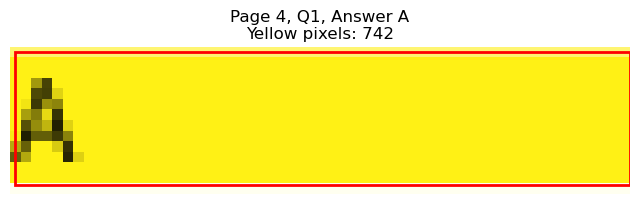

Page 4, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=77.3, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 98
Page 4, Q1, B: Yellow percentage: 0.0%


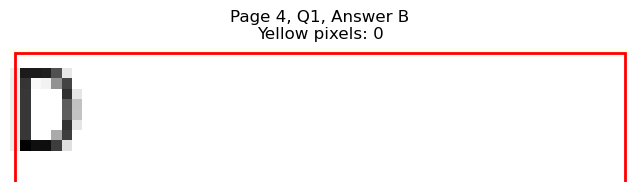

Page 4, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=341.1, y1=102.1
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 63
Page 4, Q1, C: Yellow percentage: 0.0%


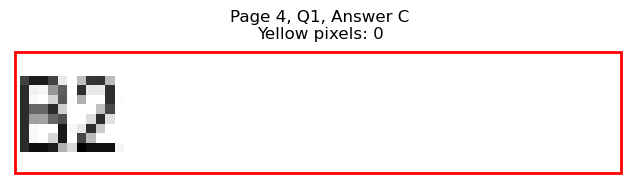

Page 4, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=341.1, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 67
Page 4, Q1, D: Yellow percentage: 0.0%


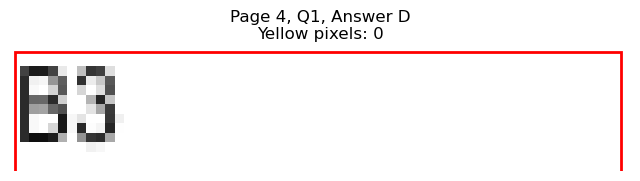


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=345.7, y1=152.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 1362
Page 4, Q2, A: Yellow percentage: 0.0%


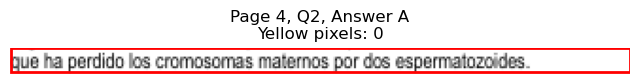

Page 4, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=336.5, y1=165.2
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 1299
Page 4, Q2, B: Yellow percentage: 0.0%


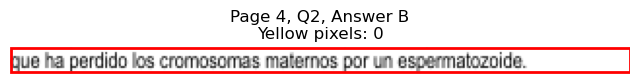

Page 4, Q2 - C: Detected box: x0=68.8, y0=165.1, x1=334.6, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 1594
Page 4, Q2, C: Yellow percentage: 0.0%


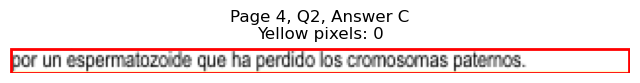

Page 4, Q2 - D: Detected box: x0=68.8, y0=177.7, x1=175.1, y1=190.4
Page 4, Q2, D: Yellow pixels: 1501
Page 4, Q2, D: Total non-white pixels: 2212
Page 4, Q2, D: Yellow percentage: 67.9%


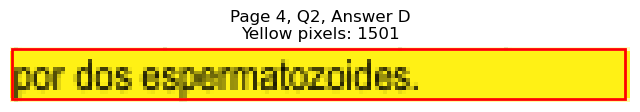


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=173.2, y1=240.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 506
Page 4, Q3, A: Yellow percentage: 0.0%


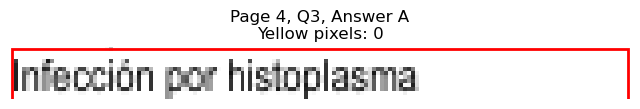

Page 4, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=149.5, y1=253.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 446
Page 4, Q3, B: Yellow percentage: 0.0%


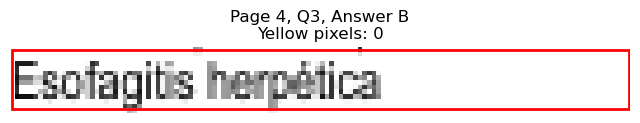

Page 4, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=376.7, y1=240.9
Page 4, Q3, C: Yellow pixels: 1085
Page 4, Q3, C: Total non-white pixels: 1300
Page 4, Q3, C: Yellow percentage: 83.5%


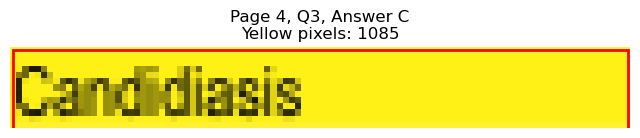

Page 4, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=403.3, y1=253.5
Page 4, Q3, D: Yellow pixels: 127
Page 4, Q3, D: Total non-white pixels: 530
Page 4, Q3, D: Yellow percentage: 24.0%


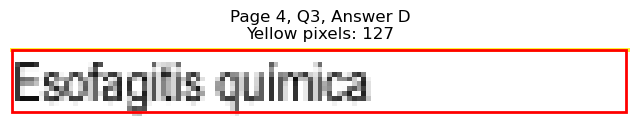


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=174.1, y1=291.5
Page 4, Q4, A: Yellow pixels: 157
Page 4, Q4, A: Total non-white pixels: 673
Page 4, Q4, A: Yellow percentage: 23.3%


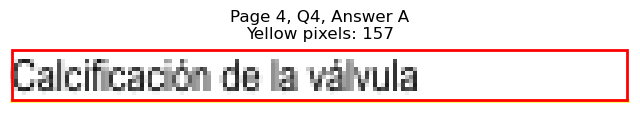

Page 4, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=220.2, y1=304.1
Page 4, Q4, B: Yellow pixels: 2041
Page 4, Q4, B: Total non-white pixels: 2842
Page 4, Q4, B: Yellow percentage: 71.8%


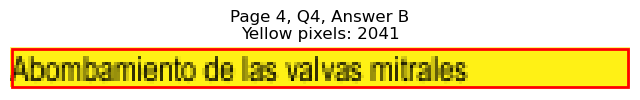

Page 4, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=431.8, y1=291.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 541
Page 4, Q4, C: Yellow percentage: 0.0%


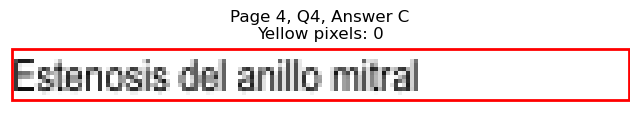

Page 4, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=432.4, y1=304.1
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 539
Page 4, Q4, D: Yellow percentage: 0.0%


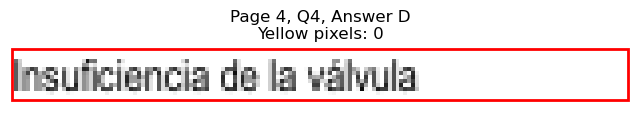


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=174.6, y1=379.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 565
Page 4, Q5, A: Yellow percentage: 0.0%


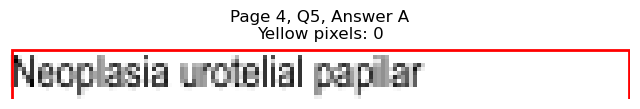

Page 4, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=192.1, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 660
Page 4, Q5, B: Yellow percentage: 0.0%


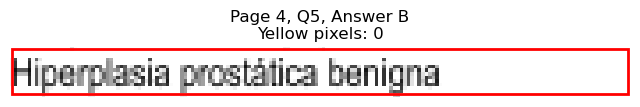

Page 4, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=426.3, y1=379.8
Page 4, Q5, C: Yellow pixels: 1565
Page 4, Q5, C: Total non-white pixels: 1950
Page 4, Q5, C: Yellow percentage: 80.3%


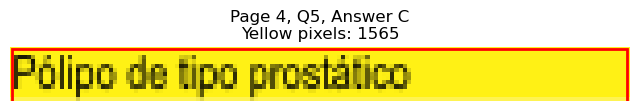

Page 4, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=424.9, y1=392.4
Page 4, Q5, D: Yellow pixels: 148
Page 4, Q5, D: Total non-white pixels: 692
Page 4, Q5, D: Yellow percentage: 21.4%


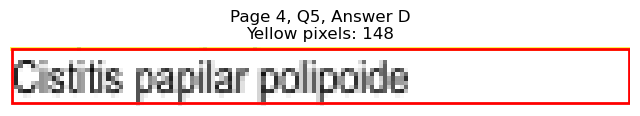


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=174.6, y1=430.3
Page 4, Q6, A: Yellow pixels: 157
Page 4, Q6, A: Total non-white pixels: 670
Page 4, Q6, A: Yellow percentage: 23.4%


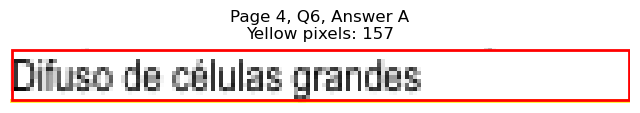

Page 4, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=169.1, y1=442.9
Page 4, Q6, B: Yellow pixels: 1560
Page 4, Q6, B: Total non-white pixels: 1976
Page 4, Q6, B: Yellow percentage: 78.9%


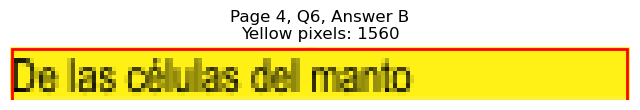

Page 4, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=407.8, y1=430.3
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 406
Page 4, Q6, C: Yellow percentage: 0.0%


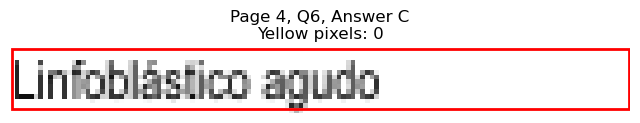

Page 4, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=374.2, y1=442.9
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 235
Page 4, Q6, D: Yellow percentage: 0.0%


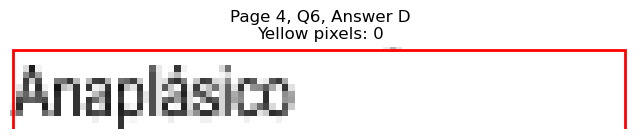


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=154.1, y1=480.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 439
Page 4, Q7, A: Yellow percentage: 0.0%


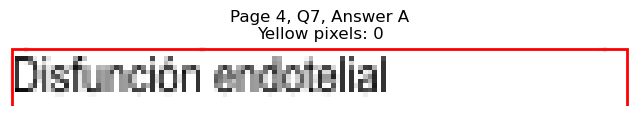

Page 4, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=174.1, y1=493.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 534
Page 4, Q7, B: Yellow percentage: 0.0%


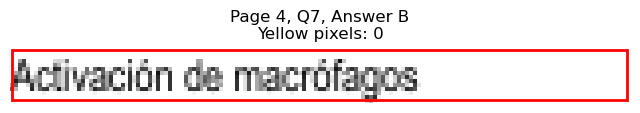

Page 4, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=397.7, y1=480.7
Page 4, Q7, C: Yellow pixels: 1293
Page 4, Q7, C: Total non-white pixels: 1573
Page 4, Q7, C: Yellow percentage: 82.2%


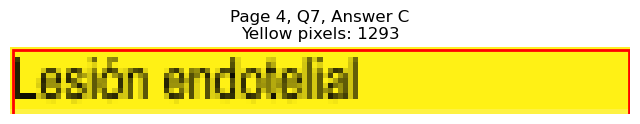

Page 4, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=452.5, y1=493.4
Page 4, Q7, D: Yellow pixels: 176
Page 4, Q7, D: Total non-white pixels: 810
Page 4, Q7, D: Yellow percentage: 21.7%


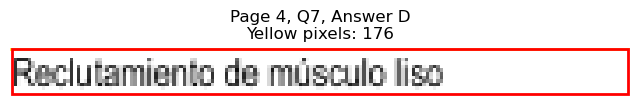


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=156.0, y1=556.4
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 402
Page 4, Q8, A: Yellow percentage: 0.0%


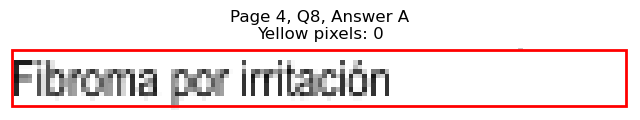

Page 4, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=150.0, y1=569.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 383
Page 4, Q8, B: Yellow percentage: 0.0%


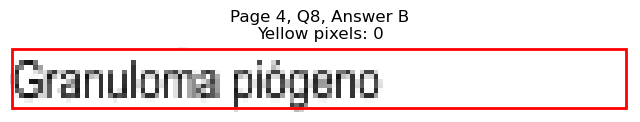

Page 4, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=443.3, y1=556.4
Page 4, Q8, C: Yellow pixels: 1693
Page 4, Q8, C: Total non-white pixels: 2338
Page 4, Q8, C: Yellow percentage: 72.4%


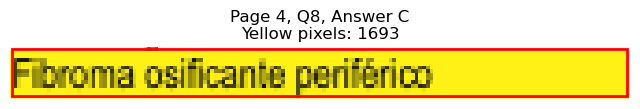

Page 4, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=494.1, y1=569.2
Page 4, Q8, D: Yellow pixels: 213
Page 4, Q8, D: Total non-white pixels: 1054
Page 4, Q8, D: Yellow percentage: 20.2%


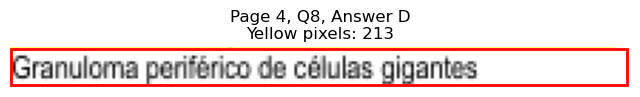


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=181.1, y1=619.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 564
Page 4, Q9, A: Yellow percentage: 0.0%


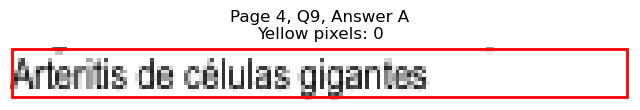

Page 4, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=148.6, y1=632.3
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 397
Page 4, Q9, B: Yellow percentage: 0.0%


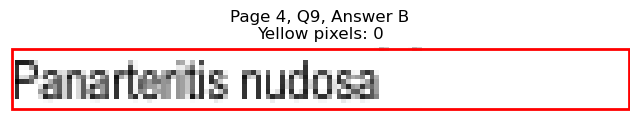

Page 4, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=432.9, y1=619.6
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 526
Page 4, Q9, C: Yellow percentage: 0.0%


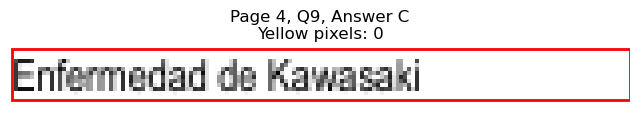

Page 4, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=414.8, y1=632.3
Page 4, Q9, D: Yellow pixels: 1319
Page 4, Q9, D: Total non-white pixels: 1932
Page 4, Q9, D: Yellow percentage: 68.3%


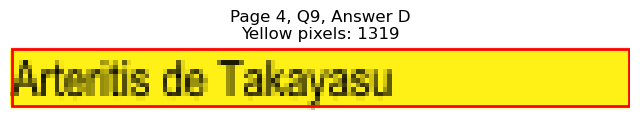


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=165.6, y1=708.0
Page 4, Q10, A: Yellow pixels: 148
Page 4, Q10, A: Total non-white pixels: 805
Page 4, Q10, A: Yellow percentage: 18.4%


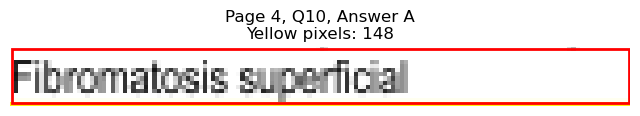

Page 4, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=133.9, y1=720.6
Page 4, Q10, B: Yellow pixels: 1277
Page 4, Q10, B: Total non-white pixels: 1624
Page 4, Q10, B: Yellow percentage: 78.6%


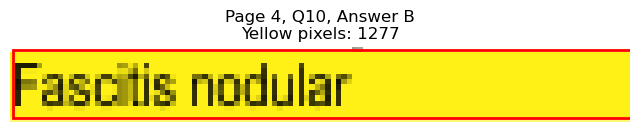

Page 4, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=397.7, y1=708.0
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 340
Page 4, Q10, C: Yellow percentage: 0.0%


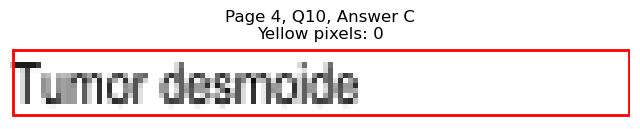

Page 4, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=429.9, y1=720.6
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 500
Page 4, Q10, D: Yellow percentage: 0.0%


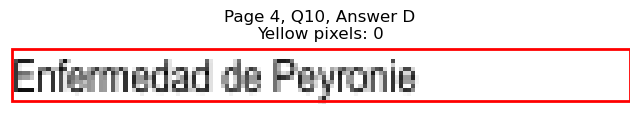


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=152.1, y1=139.9
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 419
Page 5, Q1, A: Yellow percentage: 0.0%


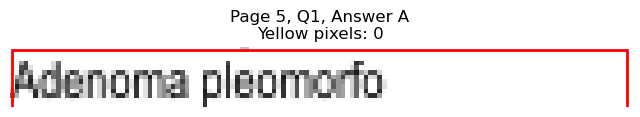

Page 5, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=118.9, y1=152.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 250
Page 5, Q1, B: Yellow percentage: 0.0%


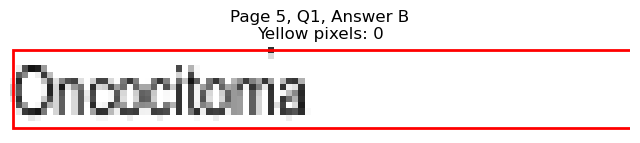

Page 5, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=445.4, y1=139.9
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 590
Page 5, Q1, C: Yellow percentage: 0.0%


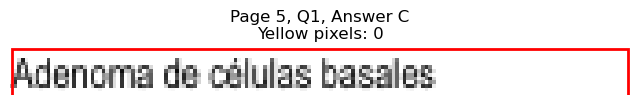

Page 5, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=402.3, y1=152.6
Page 5, Q1, D: Yellow pixels: 1366
Page 5, Q1, D: Total non-white pixels: 1764
Page 5, Q1, D: Yellow percentage: 77.4%


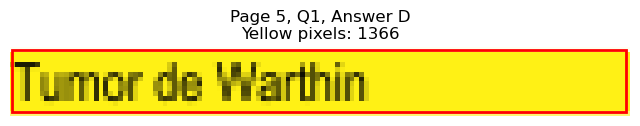


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=164.1, y1=215.6
Page 5, Q2, A: Yellow pixels: 1548
Page 5, Q2, A: Total non-white pixels: 2058
Page 5, Q2, A: Yellow percentage: 75.2%


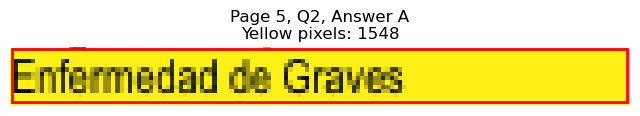

Page 5, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=174.6, y1=228.3
Page 5, Q2, B: Yellow pixels: 157
Page 5, Q2, B: Total non-white pixels: 724
Page 5, Q2, B: Yellow percentage: 21.7%


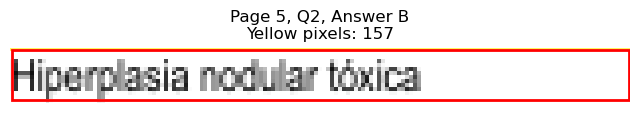

Page 5, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=428.8, y1=215.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 536
Page 5, Q2, C: Yellow percentage: 0.0%


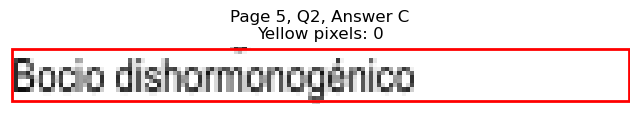

Page 5, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=418.4, y1=228.3
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 472
Page 5, Q2, D: Yellow percentage: 0.0%


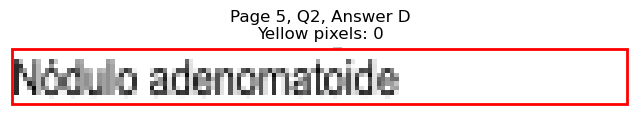


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=173.7, y1=291.5
Page 5, Q3, A: Yellow pixels: 1609
Page 5, Q3, A: Total non-white pixels: 2184
Page 5, Q3, A: Yellow percentage: 73.7%


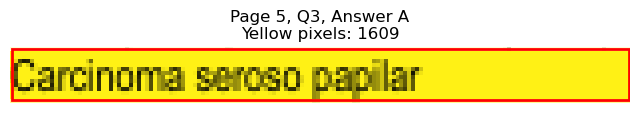

Page 5, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=212.8, y1=304.1
Page 5, Q3, B: Yellow pixels: 195
Page 5, Q3, B: Total non-white pixels: 950
Page 5, Q3, B: Yellow percentage: 20.5%


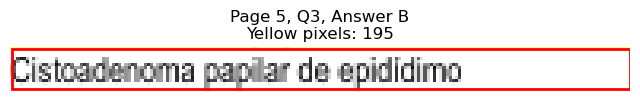

Page 5, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=448.4, y1=291.5
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 596
Page 5, Q3, C: Yellow percentage: 0.0%


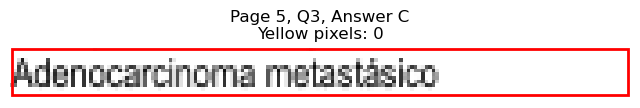

Page 5, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=415.3, y1=304.1
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 477
Page 5, Q3, D: Yellow percentage: 0.0%


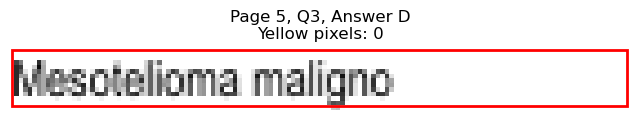


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=179.2, y1=341.9
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 553
Page 5, Q4, A: Yellow percentage: 0.0%


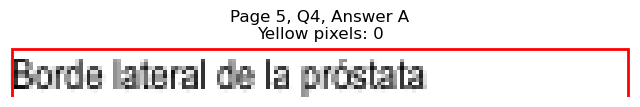

Page 5, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=121.0, y1=354.6
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 276
Page 5, Q4, B: Yellow percentage: 0.0%


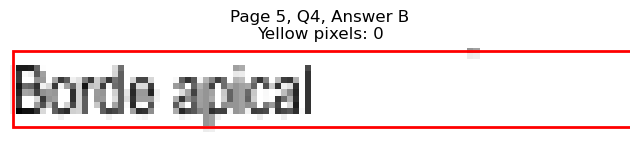

Page 5, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=413.8, y1=341.9
Page 5, Q4, C: Yellow pixels: 1445
Page 5, Q4, C: Total non-white pixels: 1781
Page 5, Q4, C: Yellow percentage: 81.1%


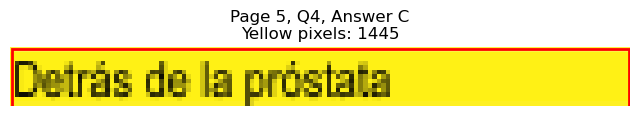

Page 5, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=502.5, y1=354.6
Page 5, Q4, D: Yellow pixels: 212
Page 5, Q4, D: Total non-white pixels: 1045
Page 5, Q4, D: Yellow percentage: 20.3%


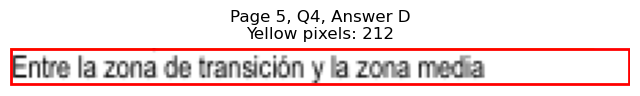


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=124.0, y1=392.4
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 251
Page 5, Q5, A: Yellow percentage: 0.0%


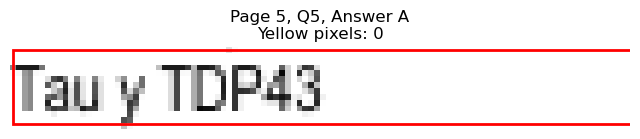

Page 5, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=133.0, y1=405.0
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 305
Page 5, Q5, B: Yellow percentage: 0.0%


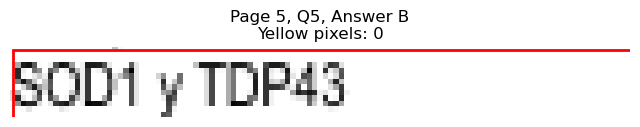

Page 5, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=378.8, y1=392.4
Page 5, Q5, C: Yellow pixels: 102
Page 5, Q5, C: Total non-white pixels: 339
Page 5, Q5, C: Yellow percentage: 30.1%


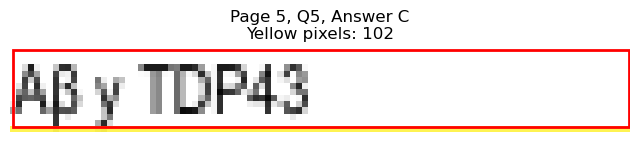

Page 5, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=363.2, y1=405.0
Page 5, Q5, D: Yellow pixels: 1014
Page 5, Q5, D: Total non-white pixels: 1131
Page 5, Q5, D: Yellow percentage: 89.7%


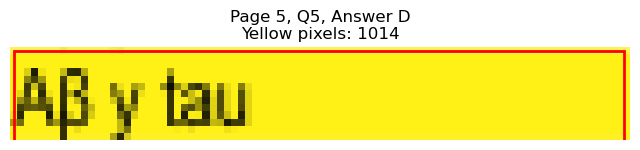


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=93.9, y1=455.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 127
Page 5, Q6, A: Yellow percentage: 0.0%


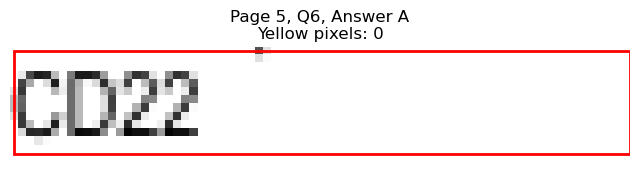

Page 5, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=93.9, y1=468.1
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 128
Page 5, Q6, B: Yellow percentage: 0.0%


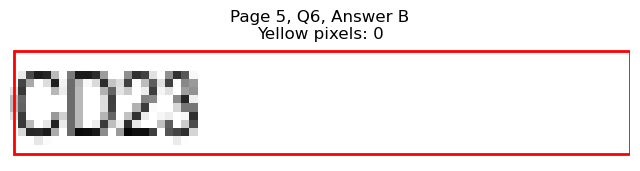

Page 5, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=353.1, y1=455.5
Page 5, Q6, C: Yellow pixels: 77
Page 5, Q6, C: Total non-white pixels: 192
Page 5, Q6, C: Yellow percentage: 40.1%


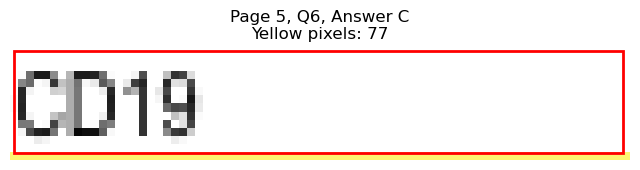

Page 5, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=353.1, y1=468.1
Page 5, Q6, D: Yellow pixels: 909
Page 5, Q6, D: Total non-white pixels: 1078
Page 5, Q6, D: Yellow percentage: 84.3%


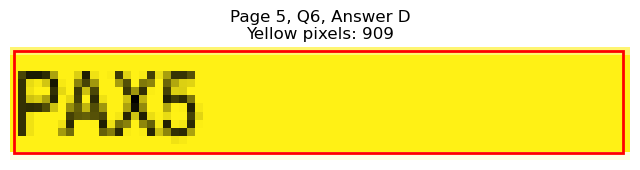


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=134.5, y1=518.6
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 357
Page 5, Q7, A: Yellow percentage: 0.0%


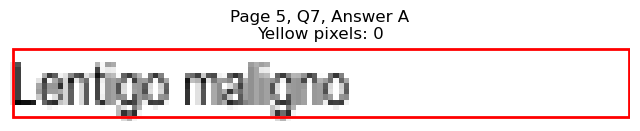

Page 5, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=171.1, y1=531.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 526
Page 5, Q7, B: Yellow percentage: 0.0%


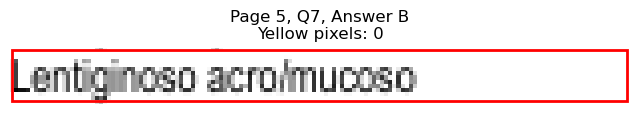

Page 5, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=412.9, y1=518.6
Page 5, Q7, C: Yellow pixels: 1423
Page 5, Q7, C: Total non-white pixels: 1904
Page 5, Q7, C: Yellow percentage: 74.7%


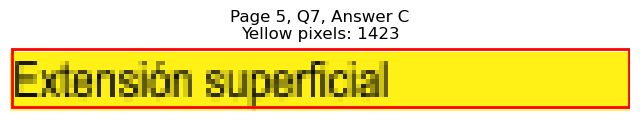

Page 5, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=397.7, y1=531.2
Page 5, Q7, D: Yellow pixels: 121
Page 5, Q7, D: Total non-white pixels: 480
Page 5, Q7, D: Yellow percentage: 25.2%


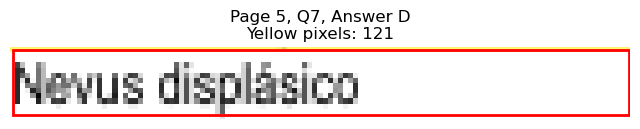


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=118.5, y1=569.2
Page 5, Q8, A: Yellow pixels: 1096
Page 5, Q8, A: Total non-white pixels: 1414
Page 5, Q8, A: Yellow percentage: 77.5%


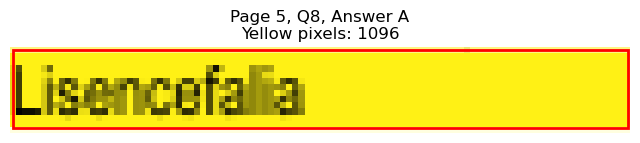

Page 5, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=124.9, y1=581.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 394
Page 5, Q8, B: Yellow percentage: 0.0%


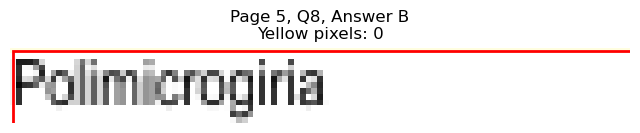

Page 5, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=402.3, y1=569.2
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 404
Page 5, Q8, C: Yellow percentage: 0.0%


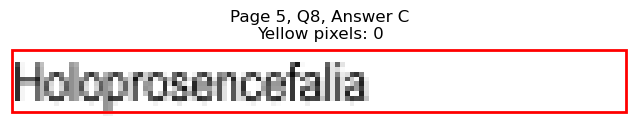

Page 5, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=378.2, y1=581.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 275
Page 5, Q8, D: Yellow percentage: 0.0%


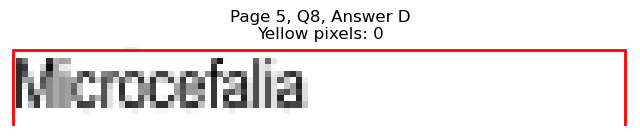


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=156.6, y1=644.9
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 441
Page 5, Q9, A: Yellow percentage: 0.0%


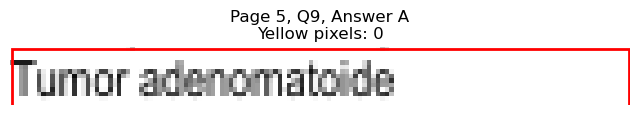

Page 5, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=122.4, y1=657.5
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 274
Page 5, Q9, B: Yellow percentage: 0.0%


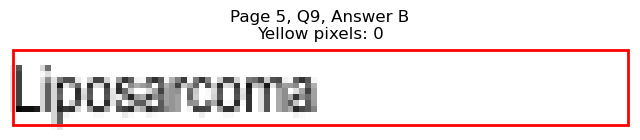

Page 5, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=541.2, y1=644.9
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 1270
Page 5, Q9, C: Yellow percentage: 0.0%


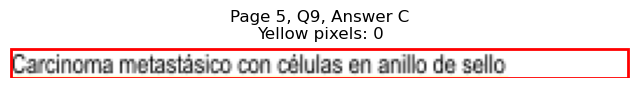

Page 5, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=389.7, y1=657.5
Page 5, Q9, D: Yellow pixels: 1252
Page 5, Q9, D: Total non-white pixels: 1582
Page 5, Q9, D: Yellow percentage: 79.1%


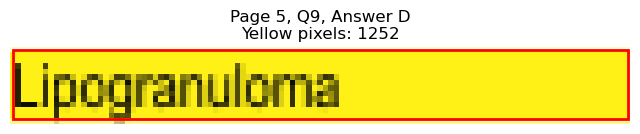


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=134.1, y1=733.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 329
Page 5, Q10, A: Yellow percentage: 0.0%


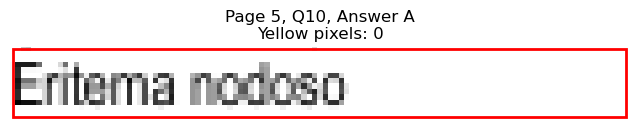

Page 5, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=199.7, y1=745.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 668
Page 5, Q10, B: Yellow percentage: 0.0%


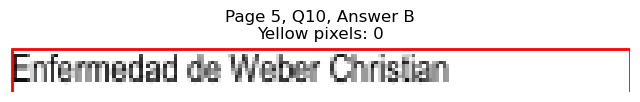

Page 5, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=401.2, y1=733.2
Page 5, Q10, C: Yellow pixels: 125
Page 5, Q10, C: Total non-white pixels: 503
Page 5, Q10, C: Yellow percentage: 24.9%


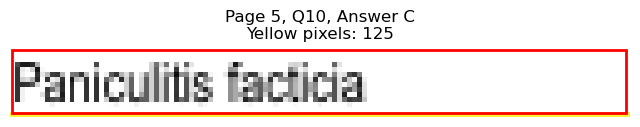

Page 5, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=398.7, y1=745.8
Page 5, Q10, D: Yellow pixels: 1300
Page 5, Q10, D: Total non-white pixels: 1586
Page 5, Q10, D: Yellow percentage: 82.0%


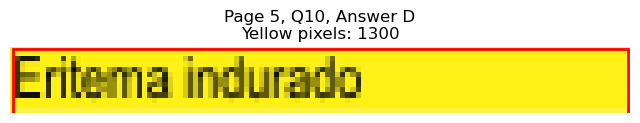


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=168.6, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 653
Page 6, Q1, A: Yellow percentage: 0.0%


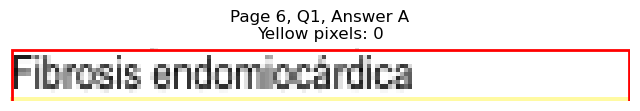

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=175.1, y1=127.3
Page 6, Q1, B: Yellow pixels: 1481
Page 6, Q1, B: Total non-white pixels: 2212
Page 6, Q1, B: Yellow percentage: 67.0%


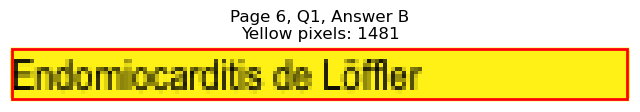

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=437.3, y1=114.7
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 593
Page 6, Q1, C: Yellow percentage: 0.0%


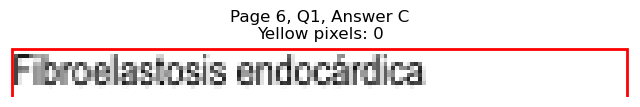

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=425.3, y1=127.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 495
Page 6, Q1, D: Yellow percentage: 0.0%


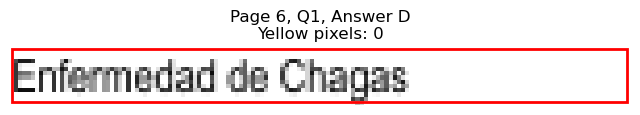


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=263.4, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 1034
Page 6, Q2, A: Yellow percentage: 0.0%


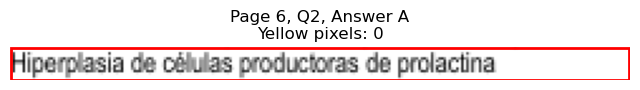

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=195.1, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 642
Page 6, Q2, B: Yellow percentage: 0.0%


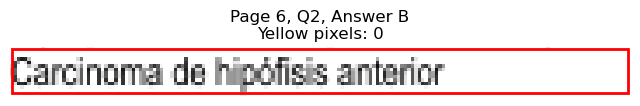

Page 6, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=410.8, y1=177.8
Page 6, Q2, C: Yellow pixels: 1428
Page 6, Q2, C: Total non-white pixels: 1742
Page 6, Q2, C: Yellow percentage: 82.0%


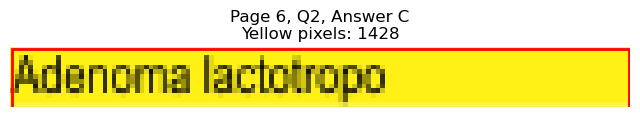

Page 6, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=465.5, y1=190.4
Page 6, Q2, D: Yellow pixels: 189
Page 6, Q2, D: Total non-white pixels: 872
Page 6, Q2, D: Yellow percentage: 21.7%


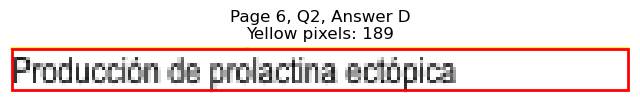


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=165.3, y1=240.9
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 497
Page 6, Q3, A: Yellow percentage: 0.0%


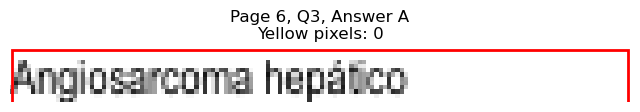

Page 6, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=143.5, y1=253.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 373
Page 6, Q3, B: Yellow percentage: 0.0%


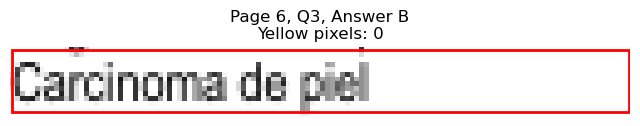

Page 6, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=421.4, y1=240.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 609
Page 6, Q3, C: Yellow percentage: 0.0%


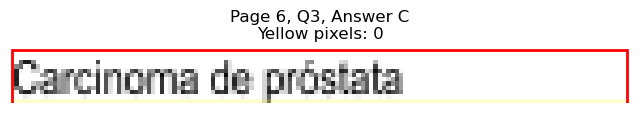

Page 6, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=418.3, y1=253.5
Page 6, Q3, D: Yellow pixels: 1509
Page 6, Q3, D: Total non-white pixels: 1988
Page 6, Q3, D: Yellow percentage: 75.9%


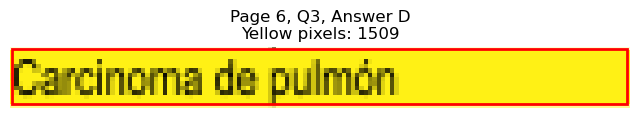


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=89.4, y1=291.5
Page 6, Q4, A: Yellow pixels: 72
Page 6, Q4, A: Total non-white pixels: 174
Page 6, Q4, A: Yellow percentage: 41.4%


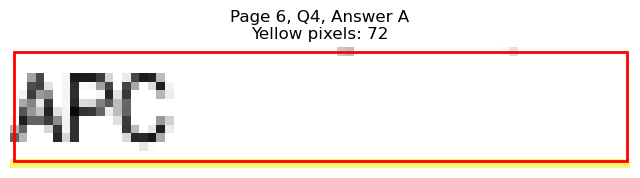

Page 6, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=87.9, y1=304.1
Page 6, Q4, B: Yellow pixels: 841
Page 6, Q4, B: Total non-white pixels: 980
Page 6, Q4, B: Yellow percentage: 85.8%


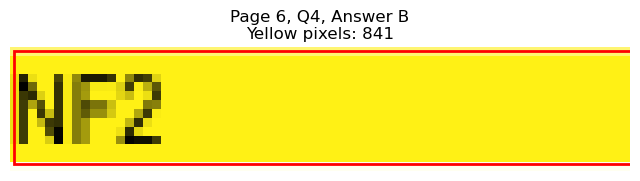

Page 6, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=349.1, y1=291.5
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 84
Page 6, Q4, C: Yellow percentage: 0.0%


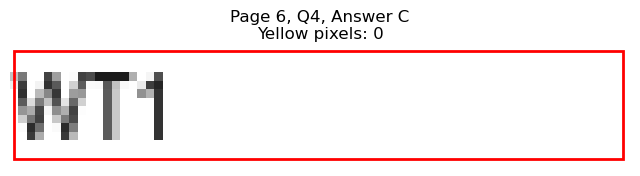

Page 6, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=346.1, y1=304.1
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 92
Page 6, Q4, D: Yellow percentage: 0.0%


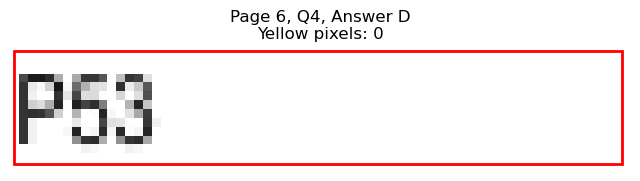


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=136.5, y1=379.8
Page 6, Q5, A: Yellow pixels: 1239
Page 6, Q5, A: Total non-white pixels: 1547
Page 6, Q5, A: Yellow percentage: 80.1%


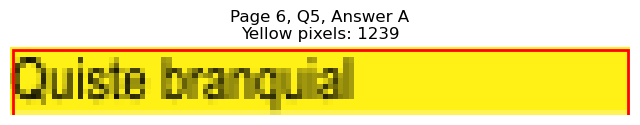

Page 6, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=201.6, y1=392.4
Page 6, Q5, B: Yellow pixels: 184
Page 6, Q5, B: Total non-white pixels: 856
Page 6, Q5, B: Yellow percentage: 21.5%


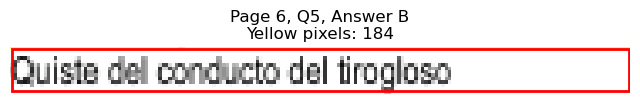

Page 6, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=412.9, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 434
Page 6, Q5, C: Yellow percentage: 0.0%


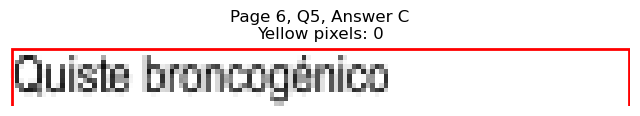

Page 6, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=466.5, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 732
Page 6, Q5, D: Yellow percentage: 0.0%


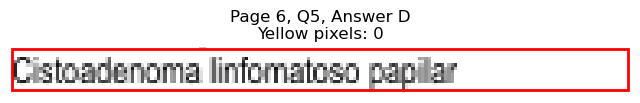


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=229.4, y1=455.5
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 813
Page 6, Q6, A: Yellow percentage: 0.0%


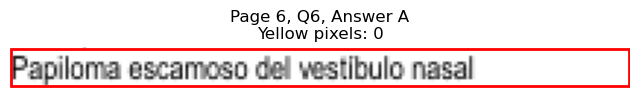

Page 6, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=207.6, y1=468.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 693
Page 6, Q6, B: Yellow percentage: 0.0%


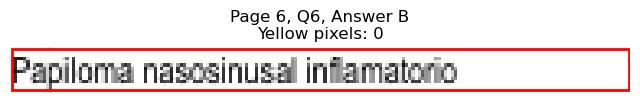

Page 6, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=391.3, y1=455.5
Page 6, Q6, C: Yellow pixels: 115
Page 6, Q6, C: Total non-white pixels: 473
Page 6, Q6, C: Yellow percentage: 24.3%


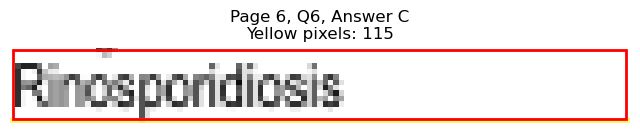

Page 6, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=476.0, y1=468.1
Page 6, Q6, D: Yellow pixels: 2037
Page 6, Q6, D: Total non-white pixels: 2800
Page 6, Q6, D: Yellow percentage: 72.8%


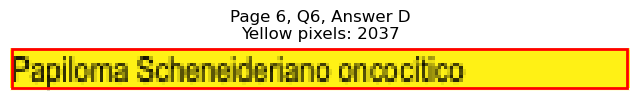


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=153.0, y1=506.0
Page 6, Q7, A: Yellow pixels: 1445
Page 6, Q7, A: Total non-white pixels: 1768
Page 6, Q7, A: Yellow percentage: 81.7%


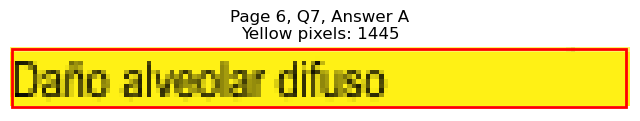

Page 6, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=115.0, y1=518.6
Page 6, Q7, B: Yellow pixels: 97
Page 6, Q7, B: Total non-white pixels: 340
Page 6, Q7, B: Yellow percentage: 28.5%


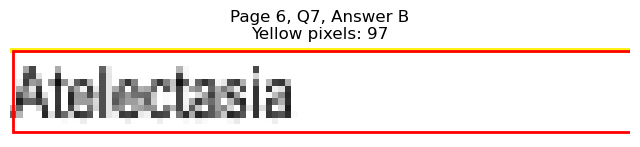

Page 6, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=367.6, y1=506.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 200
Page 6, Q7, C: Yellow percentage: 0.0%


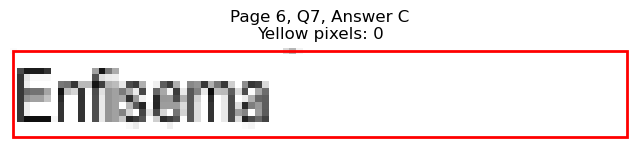

Page 6, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=457.0, y1=518.6
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 671
Page 6, Q7, D: Yellow percentage: 0.0%


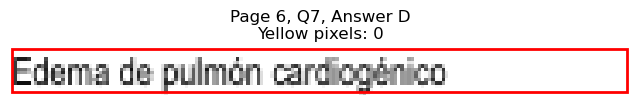


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=231.3, y1=569.2
Page 6, Q8, A: Yellow pixels: 2058
Page 6, Q8, A: Total non-white pixels: 2996
Page 6, Q8, A: Yellow percentage: 68.7%


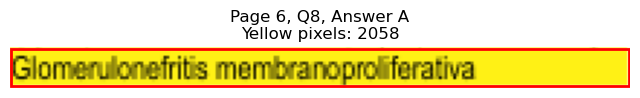

Page 6, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=198.6, y1=581.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 880
Page 6, Q8, B: Yellow percentage: 0.0%


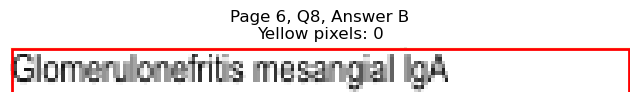

Page 6, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=494.5, y1=569.2
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 830
Page 6, Q8, C: Yellow percentage: 0.0%


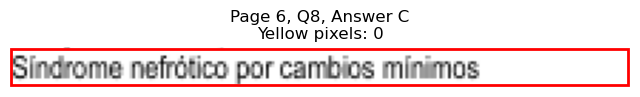

Page 6, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=433.4, y1=581.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 547
Page 6, Q8, D: Yellow percentage: 0.0%


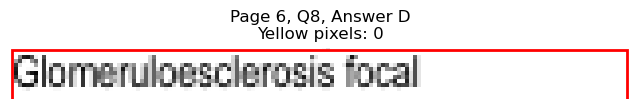


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=136.5, y1=657.5
Page 6, Q9, A: Yellow pixels: 1286
Page 6, Q9, A: Total non-white pixels: 1666
Page 6, Q9, A: Yellow percentage: 77.2%


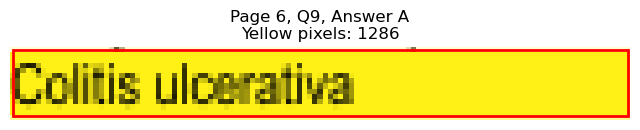

Page 6, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=159.6, y1=670.1
Page 6, Q9, B: Yellow pixels: 142
Page 6, Q9, B: Total non-white pixels: 585
Page 6, Q9, B: Yellow percentage: 24.3%


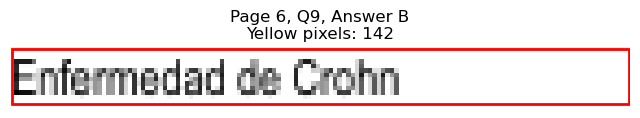

Page 6, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=439.4, y1=657.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 597
Page 6, Q9, C: Yellow percentage: 0.0%


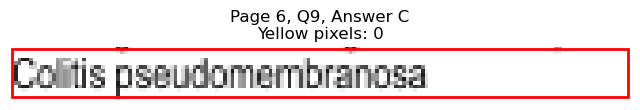

Page 6, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=409.7, y1=670.1
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 421
Page 6, Q9, D: Yellow percentage: 0.0%


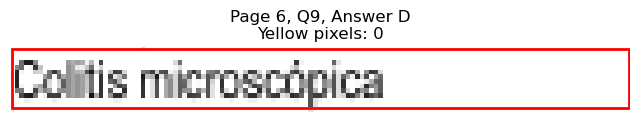


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=235.2, y1=708.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 873
Page 6, Q10, A: Yellow percentage: 0.0%


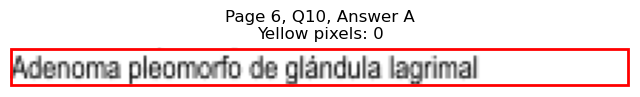

Page 6, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=137.1, y1=720.6
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 355
Page 6, Q10, B: Yellow percentage: 0.0%


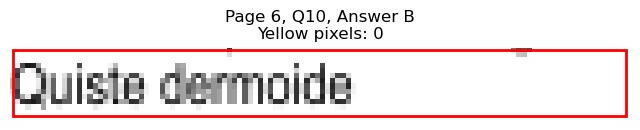

Page 6, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=473.0, y1=708.0
Page 6, Q10, C: Yellow pixels: 2008
Page 6, Q10, C: Total non-white pixels: 2565
Page 6, Q10, C: Yellow percentage: 78.3%


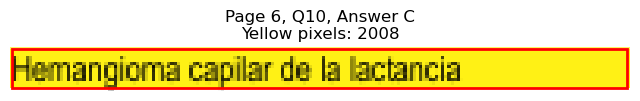

Page 6, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=383.7, y1=720.6
Page 6, Q10, D: Yellow pixels: 101
Page 6, Q10, D: Total non-white pixels: 401
Page 6, Q10, D: Yellow percentage: 25.2%


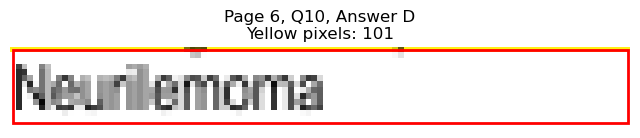


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=132.0, y1=758.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 336
Page 6, Q11, A: Yellow percentage: 0.0%


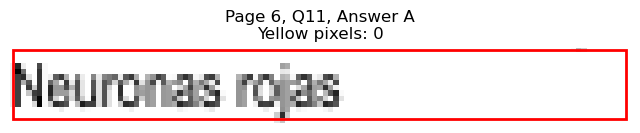

Page 6, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=142.0, y1=771.2
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 377
Page 6, Q11, B: Yellow percentage: 0.0%


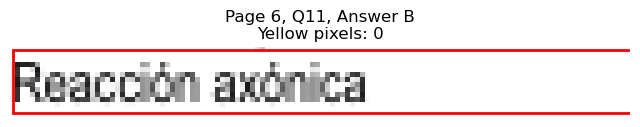

Page 6, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=357.2, y1=758.4
Page 6, Q11, C: Yellow pixels: 942
Page 6, Q11, C: Total non-white pixels: 1134
Page 6, Q11, C: Yellow percentage: 83.1%


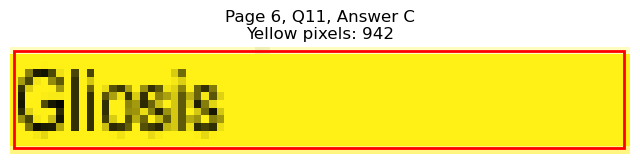

Page 6, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=410.8, y1=771.2
Page 6, Q11, D: Yellow pixels: 134
Page 6, Q11, D: Total non-white pixels: 567
Page 6, Q11, D: Yellow percentage: 23.6%


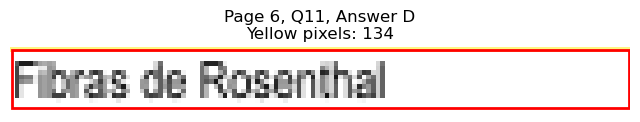


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=163.1, y1=102.1
Page 7, Q1, A: Yellow pixels: 146
Page 7, Q1, A: Total non-white pixels: 637
Page 7, Q1, A: Yellow percentage: 22.9%


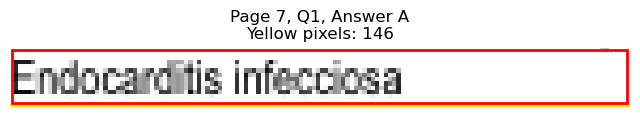

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=138.5, y1=114.7
Page 7, Q1, B: Yellow pixels: 1300
Page 7, Q1, B: Total non-white pixels: 1573
Page 7, Q1, B: Yellow percentage: 82.6%


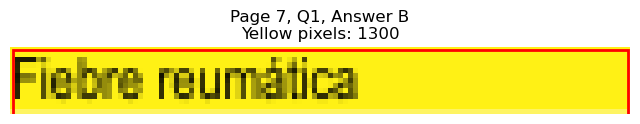

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=451.4, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 605
Page 7, Q1, C: Yellow percentage: 0.0%


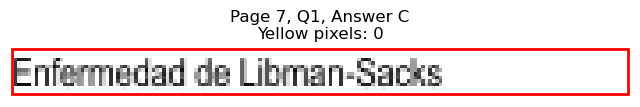

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=481.5, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 787
Page 7, Q1, D: Yellow percentage: 0.0%


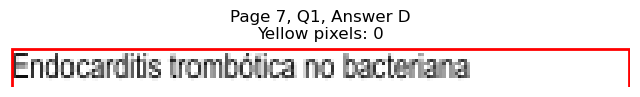


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=110.9, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 213
Page 7, Q2, A: Yellow percentage: 0.0%


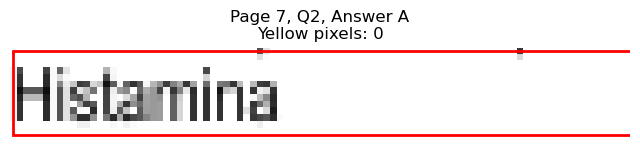

Page 7, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=131.1, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 303
Page 7, Q2, B: Yellow percentage: 0.0%


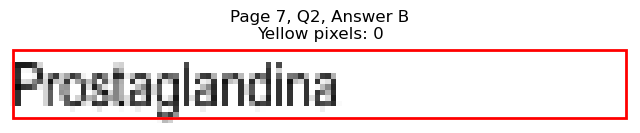

Page 7, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=348.1, y1=152.6
Page 7, Q2, C: Yellow pixels: 855
Page 7, Q2, C: Total non-white pixels: 1008
Page 7, Q2, C: Yellow percentage: 84.8%


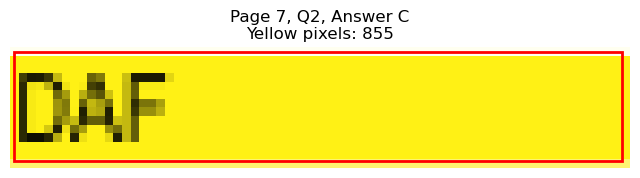

Page 7, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=355.6, y1=165.2
Page 7, Q2, D: Yellow pixels: 79
Page 7, Q2, D: Total non-white pixels: 222
Page 7, Q2, D: Yellow percentage: 35.6%


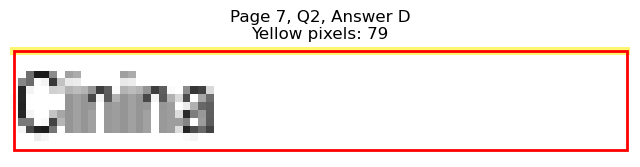


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=136.5, y1=203.0
Page 7, Q3, A: Yellow pixels: 1286
Page 7, Q3, A: Total non-white pixels: 1547
Page 7, Q3, A: Yellow percentage: 83.1%


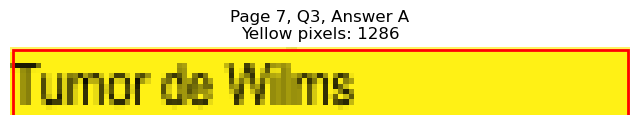

Page 7, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=210.8, y1=215.6
Page 7, Q3, B: Yellow pixels: 193
Page 7, Q3, B: Total non-white pixels: 881
Page 7, Q3, B: Yellow percentage: 21.9%


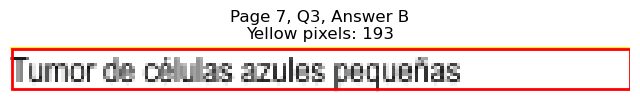

Page 7, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=418.3, y1=203.0
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 441
Page 7, Q3, C: Yellow percentage: 0.0%


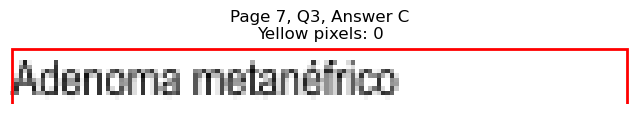

Page 7, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=379.1, y1=215.6
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 283
Page 7, Q3, D: Yellow percentage: 0.0%


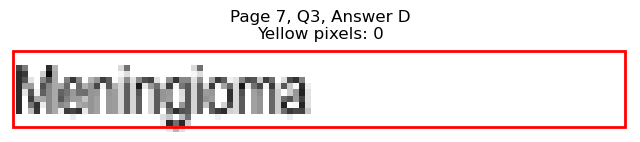


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=240.9, x1=101.9, y1=253.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 161
Page 7, Q4, A: Yellow percentage: 0.0%


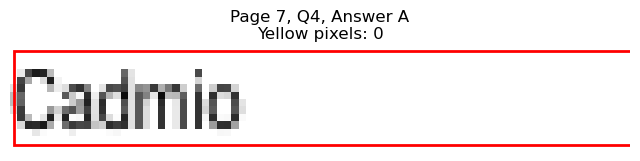

Page 7, Q4 - B: Detected box: x0=68.3, y0=253.5, x1=105.9, y1=266.1
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 194
Page 7, Q4, B: Yellow percentage: 0.0%


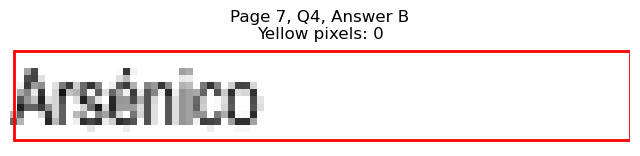

Page 7, Q4 - C: Detected box: x0=327.5, y0=240.9, x1=395.2, y1=253.5
Page 7, Q4, C: Yellow pixels: 119
Page 7, Q4, C: Total non-white pixels: 449
Page 7, Q4, C: Yellow percentage: 26.5%


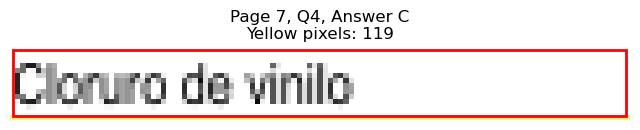

Page 7, Q4 - D: Detected box: x0=327.5, y0=253.5, x1=365.7, y1=266.1
Page 7, Q4, D: Yellow pixels: 1016
Page 7, Q4, D: Total non-white pixels: 1246
Page 7, Q4, D: Yellow percentage: 81.5%


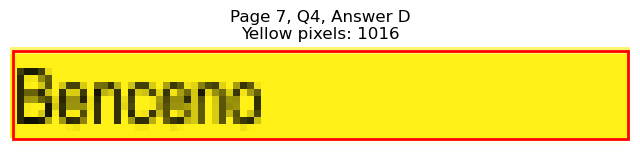


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=129.0, y1=329.3
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 313
Page 7, Q5, A: Yellow percentage: 0.0%


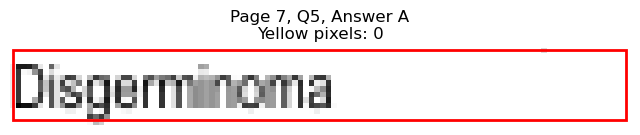

Page 7, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=133.9, y1=341.9
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 323
Page 7, Q5, B: Yellow percentage: 0.0%


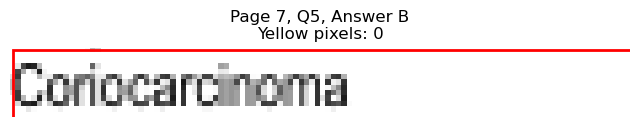

Page 7, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=422.8, y1=329.3
Page 7, Q5, C: Yellow pixels: 1390
Page 7, Q5, C: Total non-white pixels: 2044
Page 7, Q5, C: Yellow percentage: 68.0%


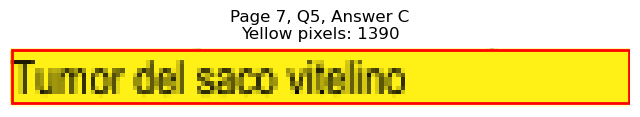

Page 7, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=423.8, y1=341.9
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 618
Page 7, Q5, D: Yellow percentage: 0.0%


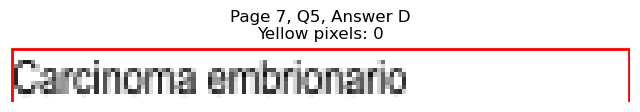


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=253.5, y1=379.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 909
Page 7, Q6, A: Yellow percentage: 0.0%


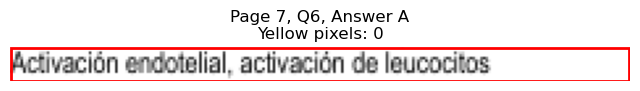

Page 7, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=345.5, y1=392.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 1361
Page 7, Q6, B: Yellow percentage: 0.0%


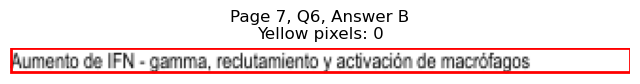

Page 7, Q6 - C: Detected box: x0=68.8, y0=392.3, x1=332.1, y1=405.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 1605
Page 7, Q6, C: Yellow percentage: 0.0%


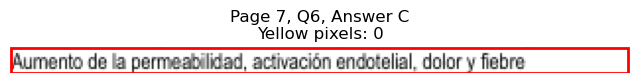

Page 7, Q6 - D: Detected box: x0=68.8, y0=404.9, x1=224.3, y1=417.6
Page 7, Q6, D: Yellow pixels: 2104
Page 7, Q6, D: Total non-white pixels: 2898
Page 7, Q6, D: Yellow percentage: 72.6%


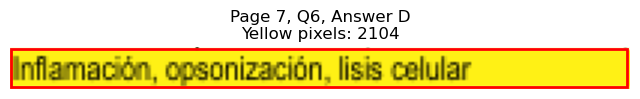


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=159.6, y1=493.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 478
Page 7, Q7, A: Yellow percentage: 0.0%


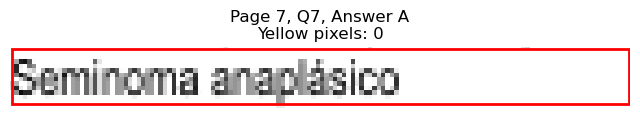

Page 7, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=180.1, y1=506.0
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 564
Page 7, Q7, B: Yellow percentage: 0.0%


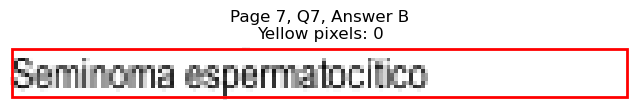

Page 7, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=423.8, y1=493.4
Page 7, Q7, C: Yellow pixels: 1389
Page 7, Q7, C: Total non-white pixels: 2058
Page 7, Q7, C: Yellow percentage: 67.5%


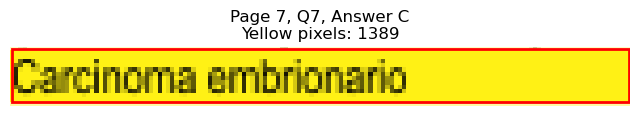

Page 7, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=422.8, y1=506.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 607
Page 7, Q7, D: Yellow percentage: 0.0%


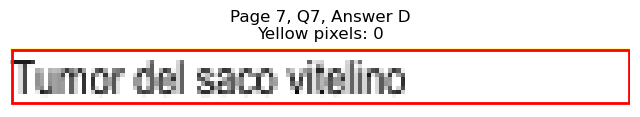


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=159.0, y1=556.4
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 485
Page 7, Q8, A: Yellow percentage: 0.0%


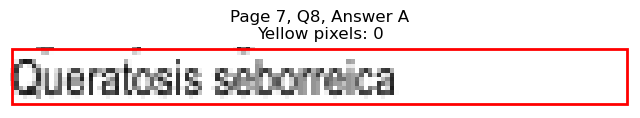

Page 7, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=148.6, y1=569.2
Page 7, Q8, B: Yellow pixels: 1365
Page 7, Q8, B: Total non-white pixels: 1834
Page 7, Q8, B: Yellow percentage: 74.4%


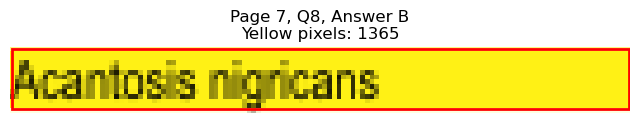

Page 7, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=359.7, y1=556.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 166
Page 7, Q8, C: Yellow percentage: 0.0%


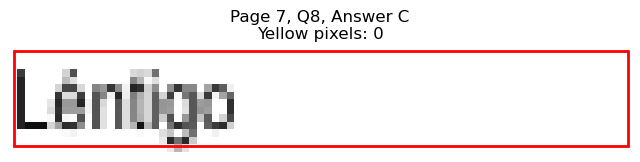

Page 7, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=408.8, y1=569.2
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 394
Page 7, Q8, D: Yellow percentage: 0.0%


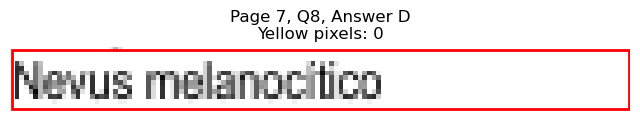


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=65.2, y1=619.6
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 70
Page 7, Q9, A: Yellow percentage: 0.0%


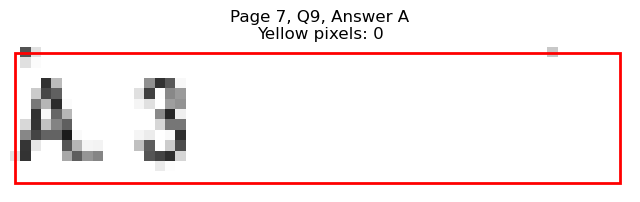

Page 7, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=80.9, y1=632.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 52
Page 7, Q9, B: Yellow percentage: 0.0%


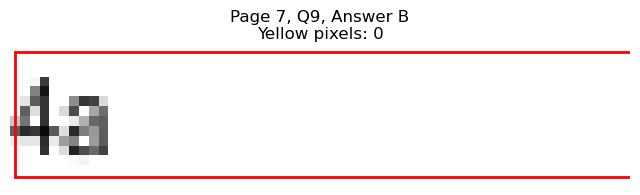

Page 7, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=340.1, y1=619.6
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 58
Page 7, Q9, C: Yellow percentage: 0.0%


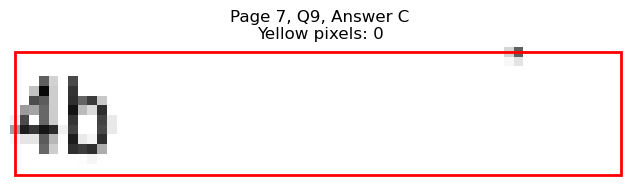

Page 7, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=324.4, y1=632.3
Page 7, Q9, D: Yellow pixels: 671
Page 7, Q9, D: Total non-white pixels: 840
Page 7, Q9, D: Yellow percentage: 79.9%


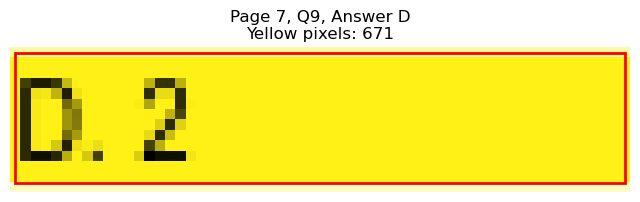


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=89.9, y1=670.1
Page 7, Q10, A: Yellow pixels: 72
Page 7, Q10, A: Total non-white pixels: 191
Page 7, Q10, A: Yellow percentage: 37.7%


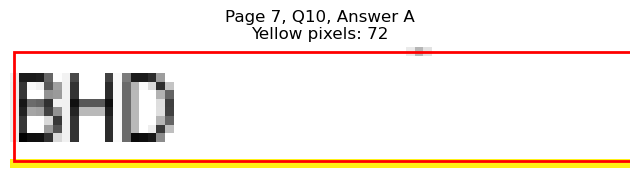

Page 7, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=97.3, y1=682.7
Page 7, Q10, B: Yellow pixels: 936
Page 7, Q10, B: Total non-white pixels: 1040
Page 7, Q10, B: Yellow percentage: 90.0%


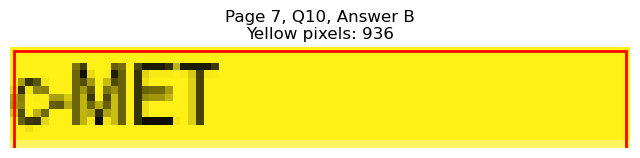

Page 7, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=347.6, y1=670.1
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 84
Page 7, Q10, C: Yellow percentage: 0.0%


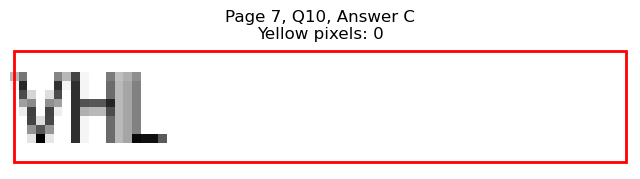

Page 7, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=342.1, y1=682.7
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 63
Page 7, Q10, D: Yellow percentage: 0.0%


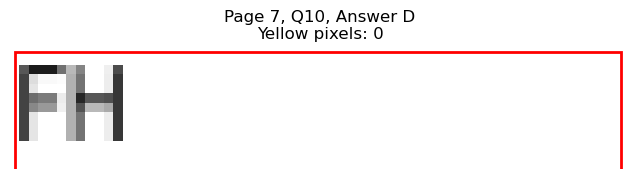


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=167.1, y1=758.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 489
Page 7, Q11, A: Yellow percentage: 0.0%


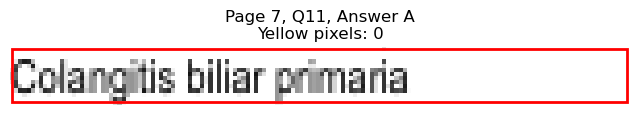

Page 7, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=199.2, y1=771.2
Page 7, Q11, B: Yellow pixels: 1832
Page 7, Q11, B: Total non-white pixels: 2548
Page 7, Q11, B: Yellow percentage: 71.9%


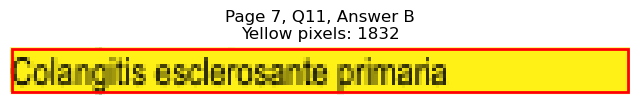

Page 7, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=421.4, y1=758.4
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 472
Page 7, Q11, C: Yellow percentage: 0.0%


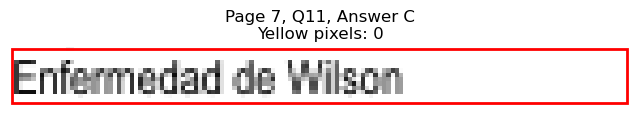

Page 7, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=446.3, y1=771.2
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 617
Page 7, Q11, D: Yellow percentage: 0.0%


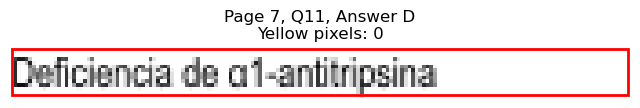


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=115.9, y1=102.1
Page 8, Q1, A: Yellow pixels: 98
Page 8, Q1, A: Total non-white pixels: 344
Page 8, Q1, A: Yellow percentage: 28.5%


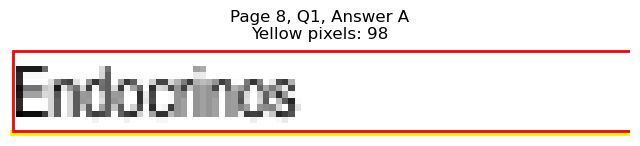

Page 8, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=141.5, y1=114.7
Page 8, Q1, B: Yellow pixels: 1348
Page 8, Q1, B: Total non-white pixels: 1612
Page 8, Q1, B: Yellow percentage: 83.6%


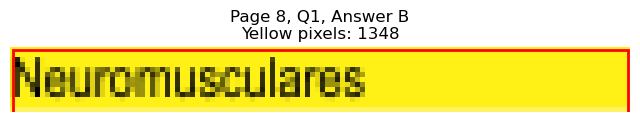

Page 8, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=389.7, y1=102.1
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 332
Page 8, Q1, C: Yellow percentage: 0.0%


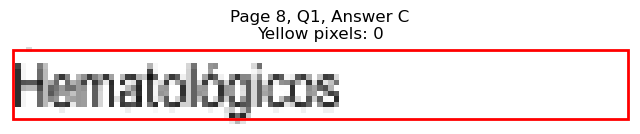

Page 8, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=392.7, y1=114.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 351
Page 8, Q1, D: Yellow percentage: 0.0%


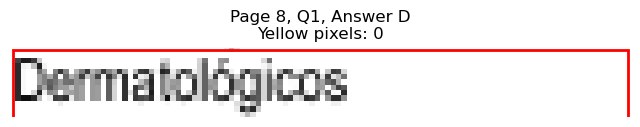


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=185.9, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 497
Page 8, Q2, A: Yellow percentage: 0.0%


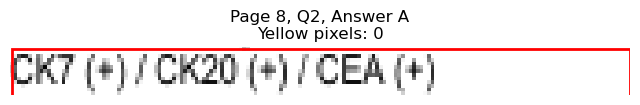

Page 8, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=179.1, y1=190.4
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 480
Page 8, Q2, B: Yellow percentage: 0.0%


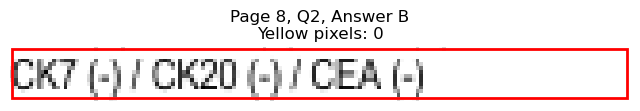

Page 8, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=440.6, y1=177.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 632
Page 8, Q2, C: Yellow percentage: 0.0%


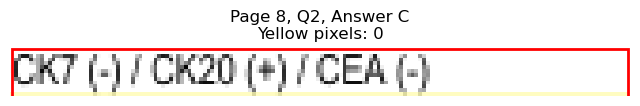

Page 8, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=442.9, y1=190.4
Page 8, Q2, D: Yellow pixels: 1606
Page 8, Q2, D: Total non-white pixels: 2324
Page 8, Q2, D: Yellow percentage: 69.1%


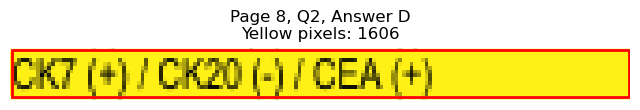


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=141.5, y1=240.9
Page 8, Q3, A: Yellow pixels: 1323
Page 8, Q3, A: Total non-white pixels: 1612
Page 8, Q3, A: Yellow percentage: 82.1%


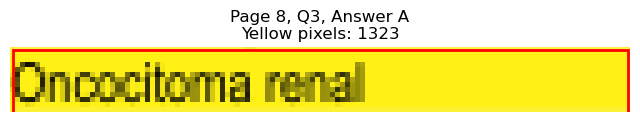

Page 8, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=135.5, y1=253.5
Page 8, Q3, B: Yellow pixels: 118
Page 8, Q3, B: Total non-white pixels: 451
Page 8, Q3, B: Yellow percentage: 26.2%


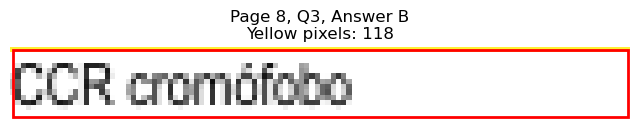

Page 8, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=484.5, y1=240.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 814
Page 8, Q3, C: Yellow percentage: 0.0%


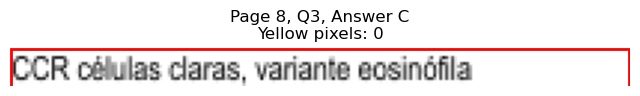

Page 8, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=437.5, y1=253.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 589
Page 8, Q3, D: Yellow percentage: 0.0%


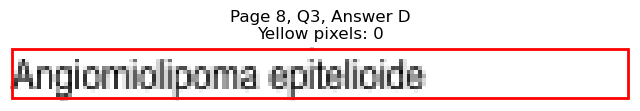


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=152.1, y1=291.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 390
Page 8, Q4, A: Yellow percentage: 0.0%


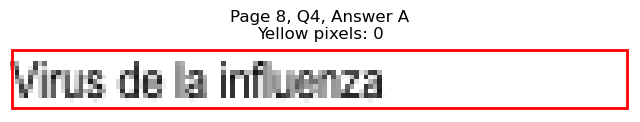

Page 8, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=88.8, y1=304.1
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 103
Page 8, Q4, B: Yellow percentage: 0.0%


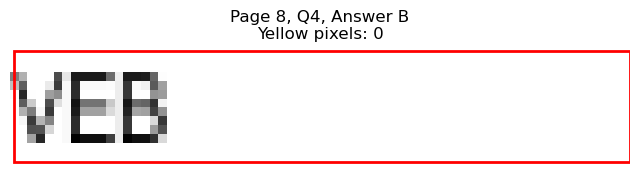

Page 8, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=394.7, y1=291.5
Page 8, Q4, C: Yellow pixels: 1289
Page 8, Q4, C: Total non-white pixels: 1652
Page 8, Q4, C: Yellow percentage: 78.0%


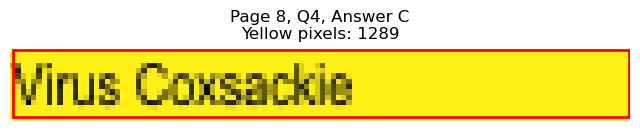

Page 8, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=406.3, y1=304.1
Page 8, Q4, D: Yellow pixels: 130
Page 8, Q4, D: Total non-white pixels: 549
Page 8, Q4, D: Yellow percentage: 23.7%


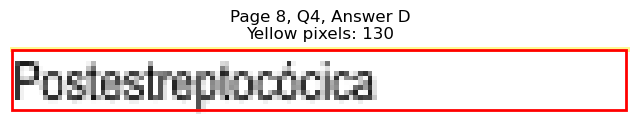


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=167.1, y1=367.2
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 456
Page 8, Q5, A: Yellow percentage: 0.0%


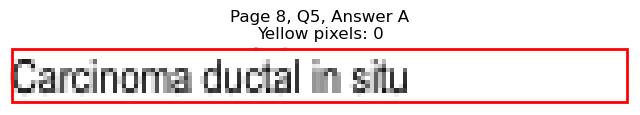

Page 8, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=189.6, y1=379.8
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 635
Page 8, Q5, B: Yellow percentage: 0.0%


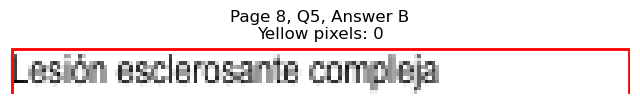

Page 8, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=420.8, y1=367.2
Page 8, Q5, C: Yellow pixels: 1503
Page 8, Q5, C: Total non-white pixels: 2016
Page 8, Q5, C: Yellow percentage: 74.6%


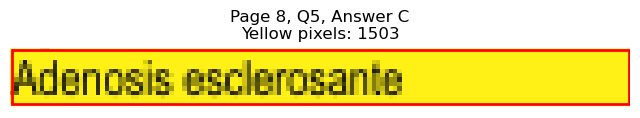

Page 8, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=455.5, y1=379.8
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 814
Page 8, Q5, D: Yellow percentage: 0.0%


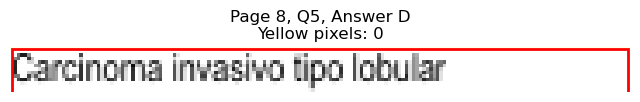


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=127.9, y1=430.3
Page 8, Q6, A: Yellow pixels: 1085
Page 8, Q6, A: Total non-white pixels: 1540
Page 8, Q6, A: Yellow percentage: 70.5%


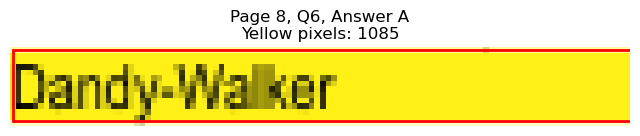

Page 8, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=154.0, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 559
Page 8, Q6, B: Yellow percentage: 0.0%


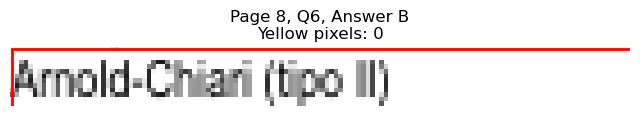

Page 8, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=388.3, y1=430.3
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 289
Page 8, Q6, C: Yellow percentage: 0.0%


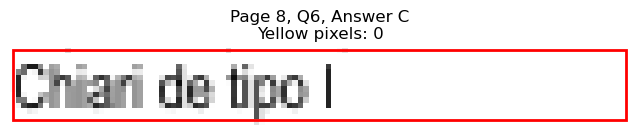

Page 8, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=374.2, y1=442.9
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 224
Page 8, Q6, D: Yellow percentage: 0.0%


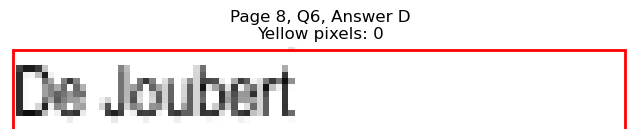


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=184.1, y1=493.4
Page 8, Q7, A: Yellow pixels: 167
Page 8, Q7, A: Total non-white pixels: 732
Page 8, Q7, A: Yellow percentage: 22.8%


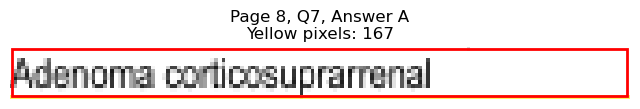

Page 8, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=138.0, y1=506.0
Page 8, Q7, B: Yellow pixels: 1315
Page 8, Q7, B: Total non-white pixels: 1573
Page 8, Q7, B: Yellow percentage: 83.6%


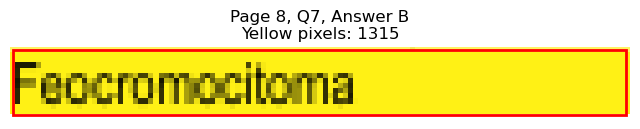

Page 8, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=448.4, y1=493.4
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 598
Page 8, Q7, C: Yellow percentage: 0.0%


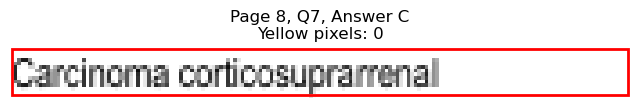

Page 8, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=373.7, y1=506.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 237
Page 8, Q7, D: Yellow percentage: 0.0%


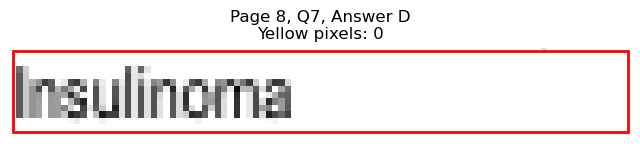


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=245.3, y1=594.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 816
Page 8, Q8, A: Yellow percentage: 0.0%


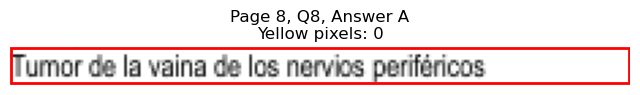

Page 8, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=230.3, y1=607.0
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 808
Page 8, Q8, B: Yellow percentage: 0.0%


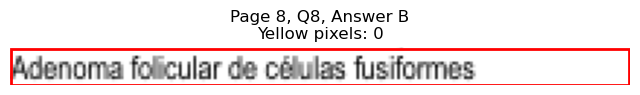

Page 8, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=458.9, y1=594.4
Page 8, Q8, C: Yellow pixels: 182
Page 8, Q8, C: Total non-white pixels: 846
Page 8, Q8, C: Yellow percentage: 21.5%


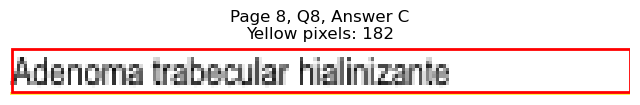

Page 8, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=419.3, y1=607.0
Page 8, Q8, D: Yellow pixels: 1519
Page 8, Q8, D: Total non-white pixels: 1859
Page 8, Q8, D: Yellow percentage: 81.7%


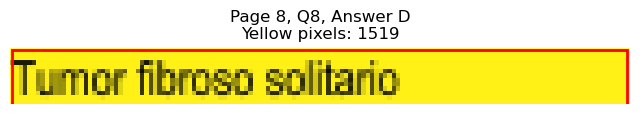


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=89.4, y1=644.9
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 100
Page 8, Q9, A: Yellow percentage: 0.0%


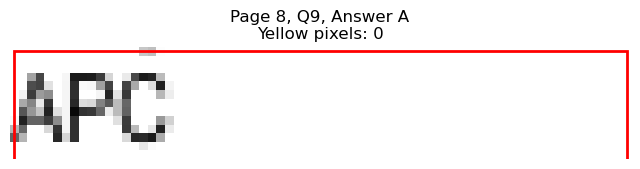

Page 8, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=92.4, y1=657.5
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 125
Page 8, Q9, B: Yellow percentage: 0.0%


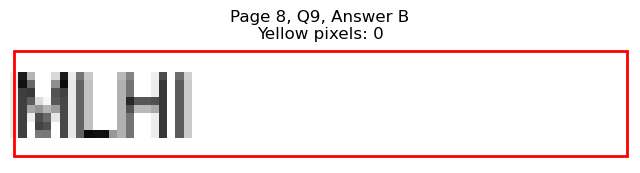

Page 8, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=350.1, y1=644.9
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 179
Page 8, Q9, C: Yellow percentage: 0.0%


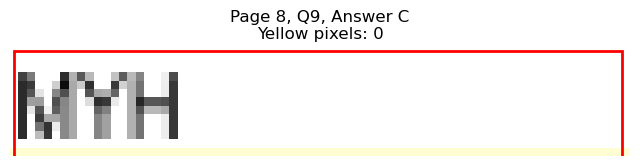

Page 8, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=355.1, y1=657.5
Page 8, Q9, D: Yellow pixels: 907
Page 8, Q9, D: Total non-white pixels: 1106
Page 8, Q9, D: Yellow percentage: 82.0%


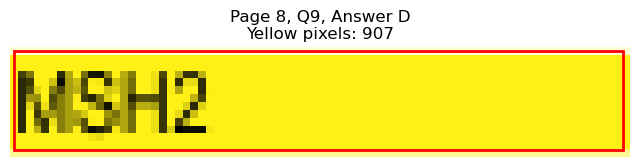


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=119.9, y1=708.0
Page 8, Q10, A: Yellow pixels: 1133
Page 8, Q10, A: Total non-white pixels: 1330
Page 8, Q10, A: Yellow percentage: 85.2%


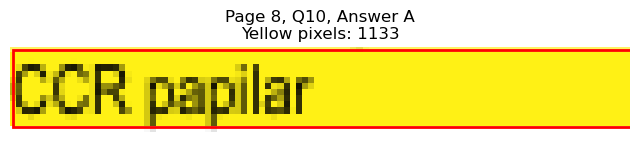

Page 8, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=228.3, y1=720.6
Page 8, Q10, B: Yellow pixels: 207
Page 8, Q10, B: Total non-white pixels: 979
Page 8, Q10, B: Yellow percentage: 21.1%


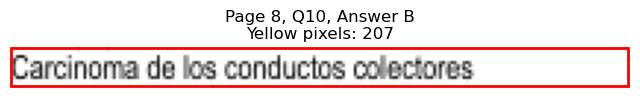

Page 8, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=444.9, y1=708.0
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 577
Page 8, Q10, C: Yellow percentage: 0.0%


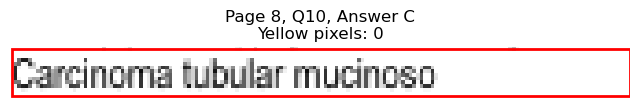

Page 8, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=418.3, y1=720.6
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 441
Page 8, Q10, D: Yellow percentage: 0.0%


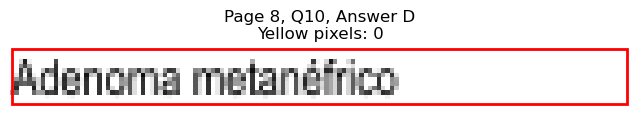


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 12 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=266.9, y1=114.7
Page 9, Q1, A: Yellow pixels: 2478
Page 9, Q1, A: Total non-white pixels: 3237
Page 9, Q1, A: Yellow percentage: 76.6%


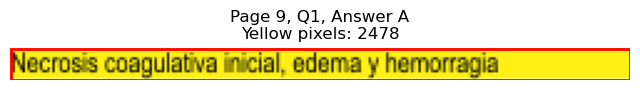

Page 9, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=201.6, y1=127.3
Page 9, Q1, B: Yellow pixels: 181
Page 9, Q1, B: Total non-white pixels: 842
Page 9, Q1, B: Yellow percentage: 21.5%


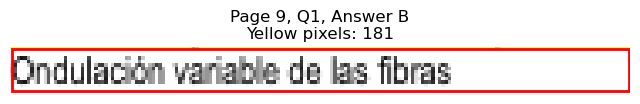

Page 9, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=258.9, y1=139.9
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 972
Page 9, Q1, C: Yellow percentage: 0.0%


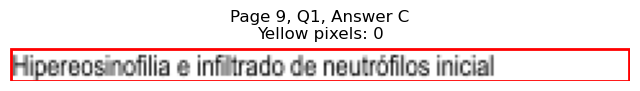

Page 9, Q1 - D: Detected box: x0=68.8, y0=139.9, x1=315.0, y1=152.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 1265
Page 9, Q1, D: Yellow percentage: 0.0%


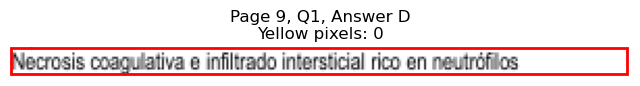


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=184.1, y1=190.4
Page 9, Q2, A: Yellow pixels: 167
Page 9, Q2, A: Total non-white pixels: 737
Page 9, Q2, A: Yellow percentage: 22.7%


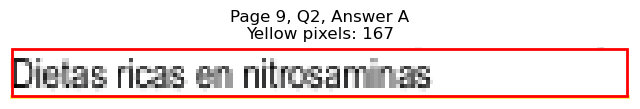

Page 9, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=196.2, y1=203.0
Page 9, Q2, B: Yellow pixels: 1817
Page 9, Q2, B: Total non-white pixels: 2327
Page 9, Q2, B: Yellow percentage: 78.1%


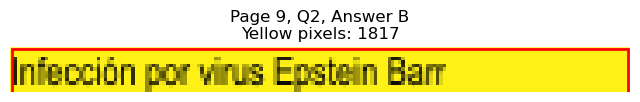

Page 9, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=379.7, y1=190.4
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 266
Page 9, Q2, C: Yellow percentage: 0.0%


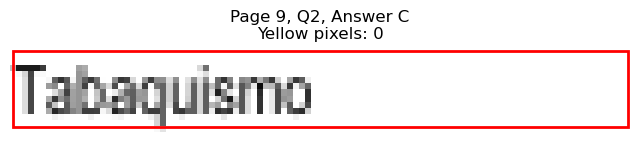

Page 9, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=370.1, y1=203.0
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 235
Page 9, Q2, D: Yellow percentage: 0.0%


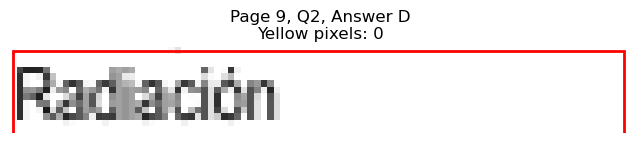


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=137.1, y1=253.5
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 337
Page 9, Q3, A: Yellow percentage: 0.0%


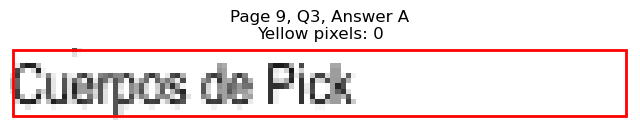

Page 9, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=141.5, y1=266.1
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 376
Page 9, Q3, B: Yellow percentage: 0.0%


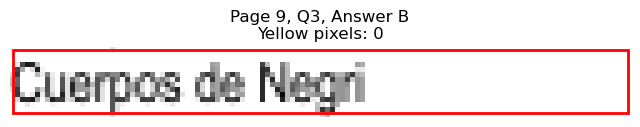

Page 9, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=407.3, y1=253.5
Page 9, Q3, C: Yellow pixels: 131
Page 9, Q3, C: Total non-white pixels: 529
Page 9, Q3, C: Yellow percentage: 24.8%


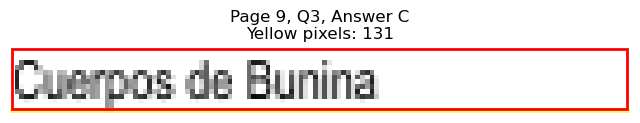

Page 9, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=400.3, y1=266.1
Page 9, Q3, D: Yellow pixels: 1324
Page 9, Q3, D: Total non-white pixels: 1736
Page 9, Q3, D: Yellow percentage: 76.3%


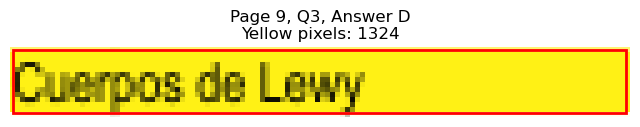


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=112.9, y1=304.1
Page 9, Q4, A: Yellow pixels: 95
Page 9, Q4, A: Total non-white pixels: 325
Page 9, Q4, A: Yellow percentage: 29.2%


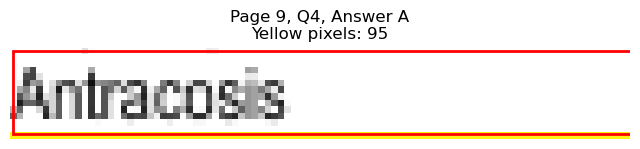

Page 9, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=114.5, y1=316.7
Page 9, Q4, B: Yellow pixels: 1075
Page 9, Q4, B: Total non-white pixels: 1261
Page 9, Q4, B: Yellow percentage: 85.2%


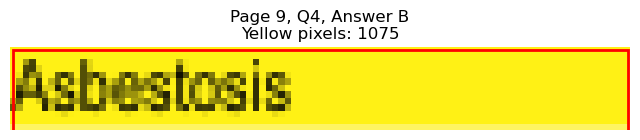

Page 9, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=362.7, y1=304.1
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 174
Page 9, Q4, C: Yellow percentage: 0.0%


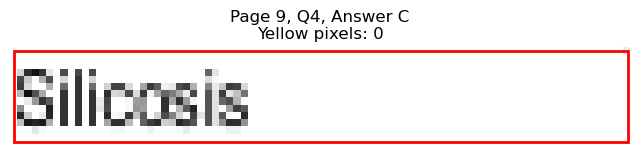

Page 9, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=366.2, y1=316.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 198
Page 9, Q4, D: Yellow percentage: 0.0%


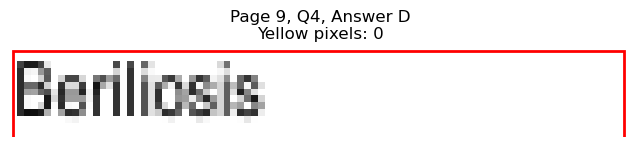


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=149.5, y1=354.6
Page 9, Q5, A: Yellow pixels: 1375
Page 9, Q5, A: Total non-white pixels: 1848
Page 9, Q5, A: Yellow percentage: 74.4%


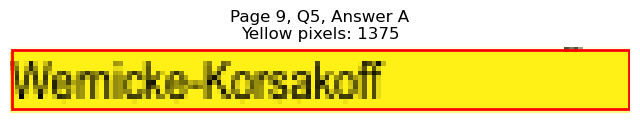

Page 9, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=113.9, y1=367.2
Page 9, Q5, B: Yellow pixels: 96
Page 9, Q5, B: Total non-white pixels: 318
Page 9, Q5, B: Yellow percentage: 30.2%


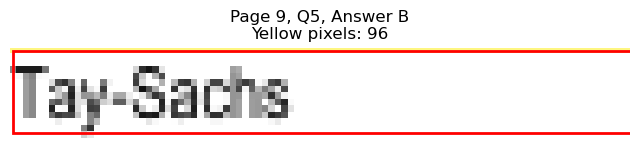

Page 9, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=386.2, y1=354.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 291
Page 9, Q5, C: Yellow percentage: 0.0%


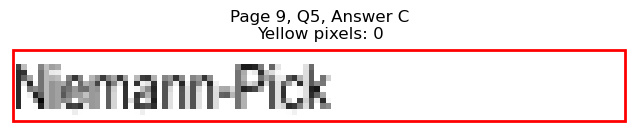

Page 9, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=359.1, y1=367.2
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 149
Page 9, Q5, D: Yellow percentage: 0.0%


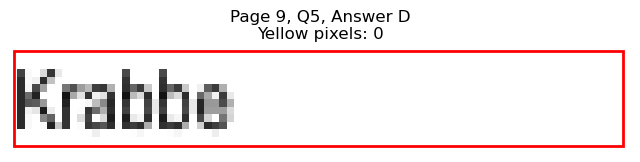


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=194.7, y1=405.0
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 621
Page 9, Q6, A: Yellow percentage: 0.0%


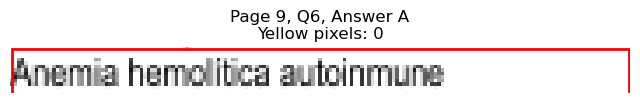

Page 9, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=138.0, y1=417.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 371
Page 9, Q6, B: Yellow percentage: 0.0%


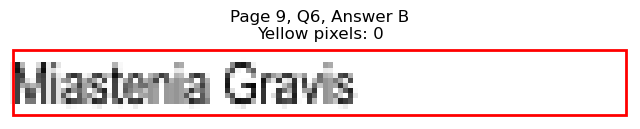

Page 9, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=436.4, y1=405.0
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 714
Page 9, Q6, C: Yellow percentage: 0.0%


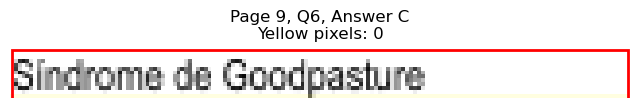

Page 9, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=368.7, y1=417.6
Page 9, Q6, D: Yellow pixels: 1042
Page 9, Q6, D: Total non-white pixels: 1288
Page 9, Q6, D: Yellow percentage: 80.9%


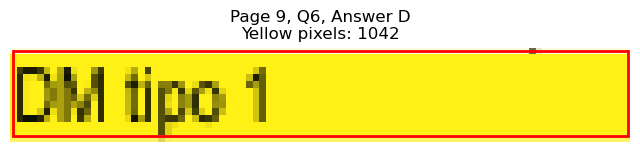


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=129.0, y1=468.1
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 320
Page 9, Q7, A: Yellow percentage: 0.0%


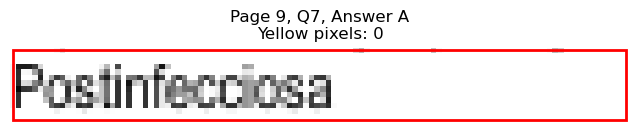

Page 9, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=160.6, y1=480.7
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 462
Page 9, Q7, B: Yellow percentage: 0.0%


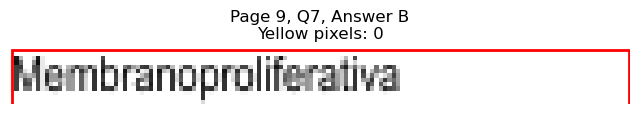

Page 9, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=382.7, y1=468.1
Page 9, Q7, C: Yellow pixels: 1155
Page 9, Q7, C: Total non-white pixels: 1484
Page 9, Q7, C: Yellow percentage: 77.8%


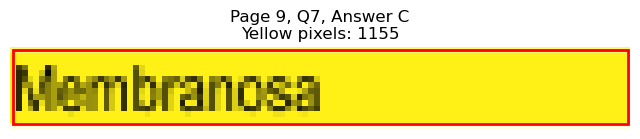

Page 9, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=428.3, y1=480.7
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 701
Page 9, Q7, D: Yellow percentage: 0.0%


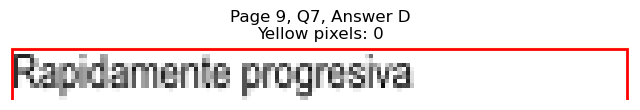


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=506.0, x1=112.5, y1=518.6
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 242
Page 9, Q8, A: Yellow percentage: 0.0%


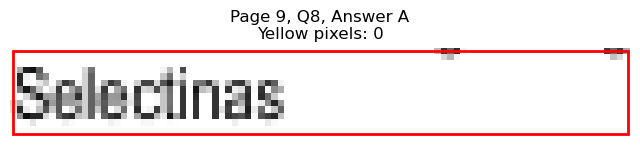

Page 9, Q8 - B: Detected box: x0=68.3, y0=518.6, x1=113.9, y1=531.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 242
Page 9, Q8, B: Yellow percentage: 0.0%


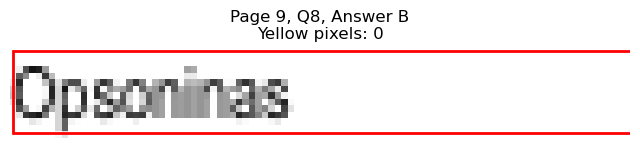

Page 9, Q8 - C: Detected box: x0=327.5, y0=506.0, x1=369.7, y1=518.6
Page 9, Q8, C: Yellow pixels: 1039
Page 9, Q8, C: Total non-white pixels: 1302
Page 9, Q8, C: Yellow percentage: 79.8%


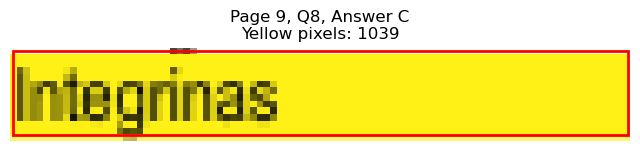

Page 9, Q8 - D: Detected box: x0=327.5, y0=518.6, x1=400.3, y1=531.2
Page 9, Q8, D: Yellow pixels: 122
Page 9, Q8, D: Total non-white pixels: 467
Page 9, Q8, D: Yellow percentage: 26.1%


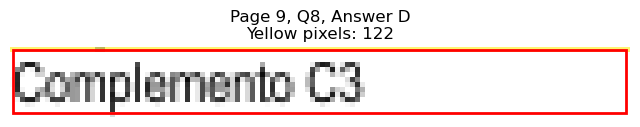


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=171.1, y1=569.2
Page 9, Q9, A: Yellow pixels: 154
Page 9, Q9, A: Total non-white pixels: 658
Page 9, Q9, A: Yellow percentage: 23.4%


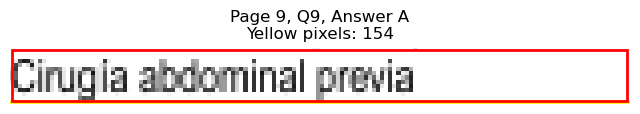

Page 9, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=226.8, y1=581.8
Page 9, Q9, B: Yellow pixels: 2088
Page 9, Q9, B: Total non-white pixels: 2717
Page 9, Q9, B: Yellow percentage: 76.8%


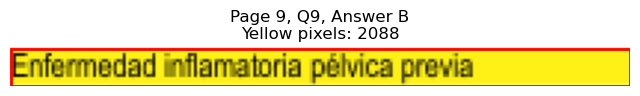

Page 9, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=387.2, y1=569.2
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 297
Page 9, Q9, C: Yellow percentage: 0.0%


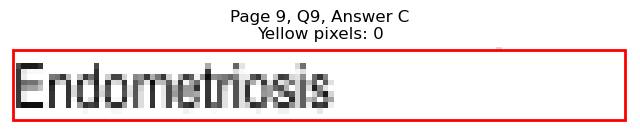

Page 9, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=459.9, y1=581.8
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 686
Page 9, Q9, D: Yellow percentage: 0.0%


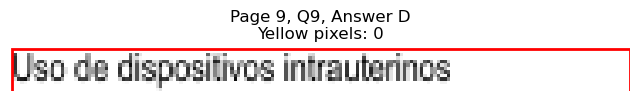


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=188.7, y1=619.6
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 576
Page 9, Q10, A: Yellow percentage: 0.0%


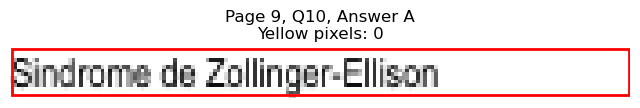

Page 9, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=127.9, y1=632.3
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 301
Page 9, Q10, B: Yellow percentage: 0.0%


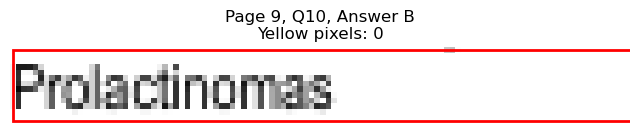

Page 9, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=443.3, y1=619.6
Page 9, Q10, C: Yellow pixels: 1688
Page 9, Q10, C: Total non-white pixels: 2338
Page 9, Q10, C: Yellow percentage: 72.2%


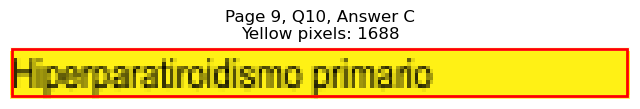

Page 9, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=381.2, y1=632.3
Page 9, Q10, D: Yellow pixels: 105
Page 9, Q10, D: Total non-white pixels: 369
Page 9, Q10, D: Yellow percentage: 28.5%


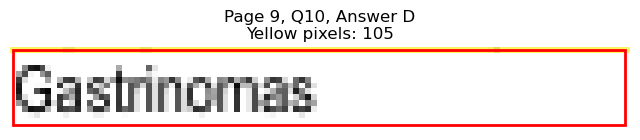


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=657.5, x1=124.0, y1=670.1
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 275
Page 9, Q11, A: Yellow percentage: 0.0%


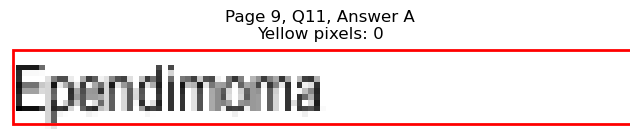

Page 9, Q11 - B: Detected box: x0=68.3, y0=670.1, x1=118.5, y1=682.7
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 267
Page 9, Q11, B: Yellow percentage: 0.0%


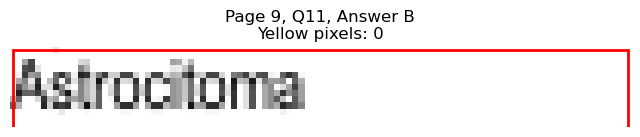

Page 9, Q11 - C: Detected box: x0=327.5, y0=657.5, x1=396.3, y1=670.1
Page 9, Q11, C: Yellow pixels: 1247
Page 9, Q11, C: Total non-white pixels: 1680
Page 9, Q11, C: Yellow percentage: 74.2%


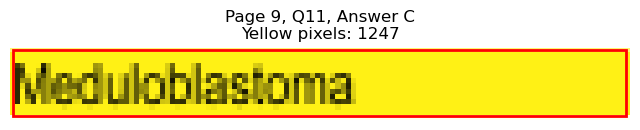

Page 9, Q11 - D: Detected box: x0=327.5, y0=670.1, x1=408.3, y1=682.7
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 547
Page 9, Q11, D: Yellow percentage: 0.0%


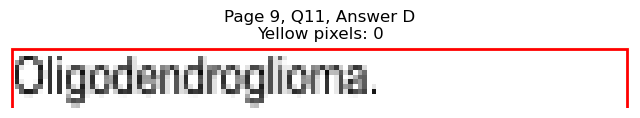


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)




Page 9, Q12 - A: Detected box: x0=68.3, y0=720.6, x1=121.0, y1=733.2
Page 9, Q12, A: Yellow pixels: 1132
Page 9, Q12, A: Total non-white pixels: 1442
Page 9, Q12, A: Yellow percentage: 78.5%


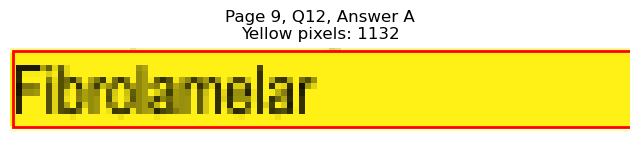

Page 9, Q12 - B: Detected box: x0=68.3, y0=733.2, x1=98.9, y1=745.8
Page 9, Q12, B: Yellow pixels: 0
Page 9, Q12, B: Total non-white pixels: 219
Page 9, Q12, B: Yellow percentage: 0.0%


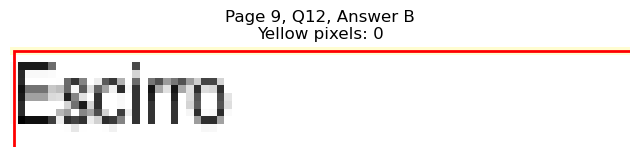

Page 9, Q12 - C: Detected box: x0=327.5, y0=720.6, x1=385.7, y1=733.2
Page 9, Q12, C: Yellow pixels: 0
Page 9, Q12, C: Total non-white pixels: 310
Page 9, Q12, C: Yellow percentage: 0.0%


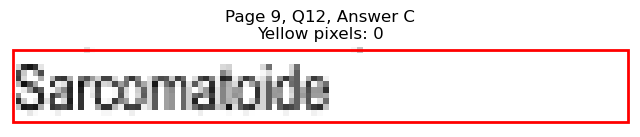

Page 9, Q12 - D: Detected box: x0=327.5, y0=733.2, x1=387.8, y1=745.8
Page 9, Q12, D: Yellow pixels: 0
Page 9, Q12, D: Total non-white pixels: 326
Page 9, Q12, D: Yellow percentage: 0.0%


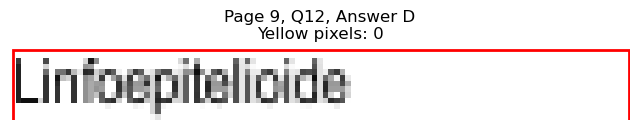


Page 9, Q12 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 6 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=94.3, y1=102.1
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 109
Page 10, Q1, A: Yellow percentage: 0.0%


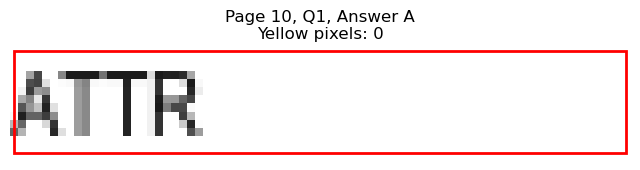

Page 10, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=81.9, y1=114.7
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 73
Page 10, Q1, B: Yellow percentage: 0.0%


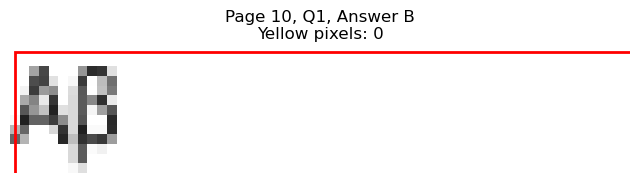

Page 10, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=353.7, y1=102.1
Page 10, Q1, C: Yellow pixels: 905
Page 10, Q1, C: Total non-white pixels: 1078
Page 10, Q1, C: Yellow percentage: 84.0%


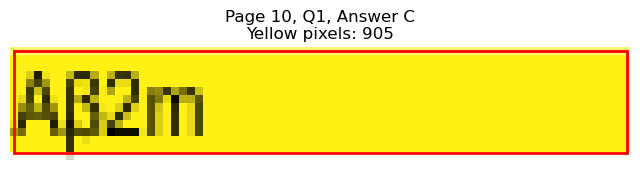

Page 10, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=342.1, y1=114.7
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 126
Page 10, Q1, D: Yellow percentage: 0.0%


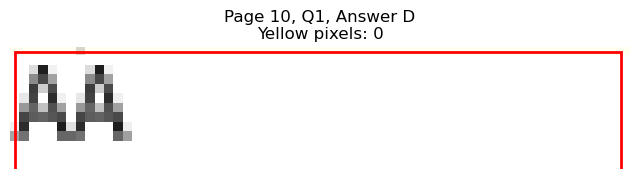


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=183.1, y1=165.2
Page 10, Q2, A: Yellow pixels: 166
Page 10, Q2, A: Total non-white pixels: 743
Page 10, Q2, A: Yellow percentage: 22.3%


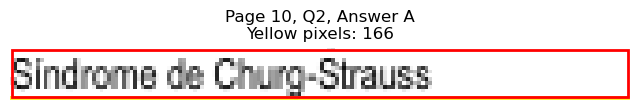

Page 10, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=178.1, y1=177.8
Page 10, Q2, B: Yellow pixels: 1660
Page 10, Q2, B: Total non-white pixels: 2093
Page 10, Q2, B: Yellow percentage: 79.3%


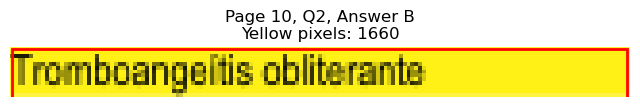

Page 10, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=436.9, y1=165.2
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 559
Page 10, Q2, C: Yellow percentage: 0.0%


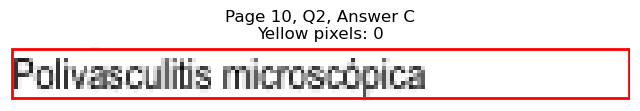

Page 10, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=432.9, y1=177.8
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 527
Page 10, Q2, D: Yellow percentage: 0.0%


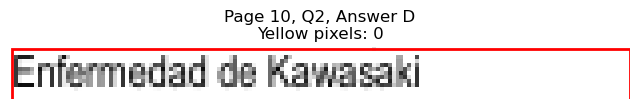


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=221.7, y1=240.9
Page 10, Q3, A: Yellow pixels: 2027
Page 10, Q3, A: Total non-white pixels: 2652
Page 10, Q3, A: Yellow percentage: 76.4%


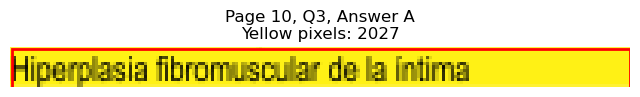

Page 10, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=144.5, y1=253.5
Page 10, Q3, B: Yellow pixels: 124
Page 10, Q3, B: Total non-white pixels: 534
Page 10, Q3, B: Yellow percentage: 23.2%


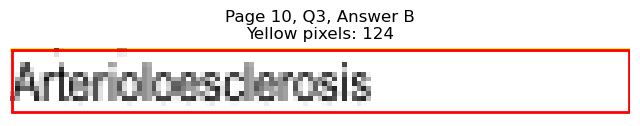

Page 10, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=485.0, y1=240.9
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 800
Page 10, Q3, C: Yellow percentage: 0.0%


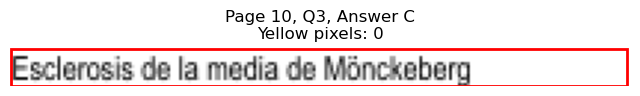

Page 10, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=391.7, y1=253.5
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 340
Page 10, Q3, D: Yellow percentage: 0.0%


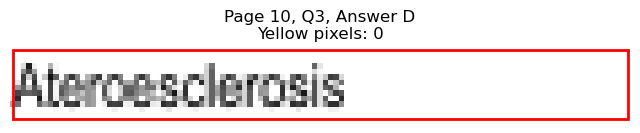


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=107.4, y1=291.5
Page 10, Q4, A: Yellow pixels: 90
Page 10, Q4, A: Total non-white pixels: 292
Page 10, Q4, A: Yellow percentage: 30.8%


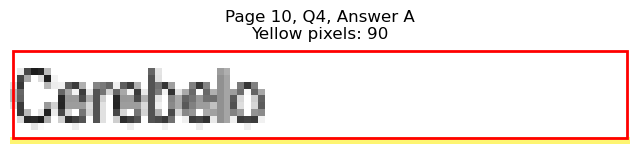

Page 10, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=140.1, y1=304.1
Page 10, Q4, B: Yellow pixels: 1318
Page 10, Q4, B: Total non-white pixels: 1722
Page 10, Q4, B: Yellow percentage: 76.5%


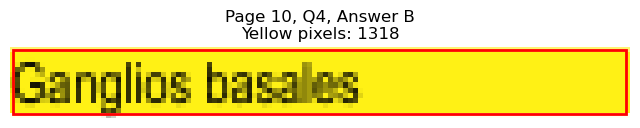

Page 10, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=386.2, y1=291.5
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 310
Page 10, Q4, C: Yellow percentage: 0.0%


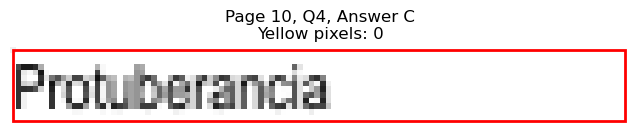

Page 10, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=384.8, y1=304.1
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 274
Page 10, Q4, D: Yellow percentage: 0.0%


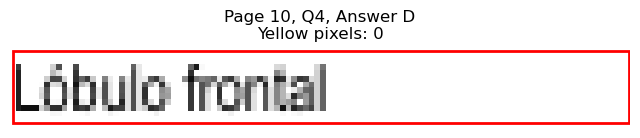


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=139.0, y1=367.2
Page 10, Q5, A: Yellow pixels: 121
Page 10, Q5, A: Total non-white pixels: 485
Page 10, Q5, A: Yellow percentage: 24.9%


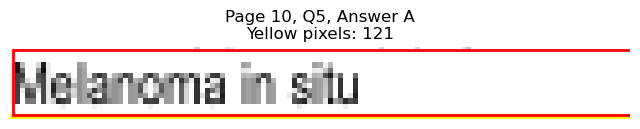

Page 10, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=216.3, y1=379.8
Page 10, Q5, B: Yellow pixels: 2017
Page 10, Q5, B: Total non-white pixels: 2587
Page 10, Q5, B: Yellow percentage: 78.0%


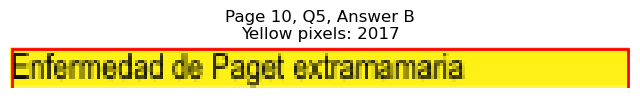

Page 10, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=413.8, y1=367.2
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 472
Page 10, Q5, C: Yellow percentage: 0.0%


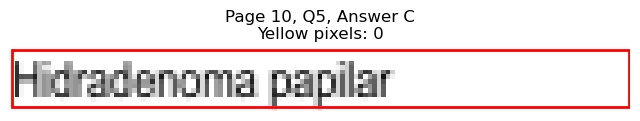

Page 10, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=447.4, y1=379.8
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 659
Page 10, Q5, D: Yellow percentage: 0.0%


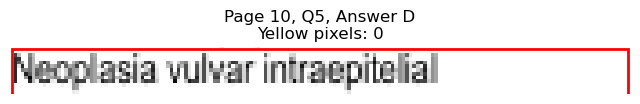


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=131.5, y1=442.9
Page 10, Q6, A: Yellow pixels: 1225
Page 10, Q6, A: Total non-white pixels: 1482
Page 10, Q6, A: Yellow percentage: 82.7%


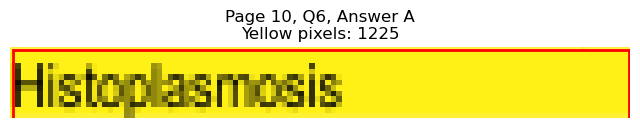

Page 10, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=124.9, y1=455.5
Page 10, Q6, B: Yellow pixels: 105
Page 10, Q6, B: Total non-white pixels: 413
Page 10, Q6, B: Yellow percentage: 25.4%


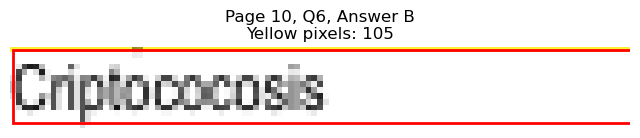

Page 10, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=385.3, y1=442.9
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 295
Page 10, Q6, C: Yellow percentage: 0.0%


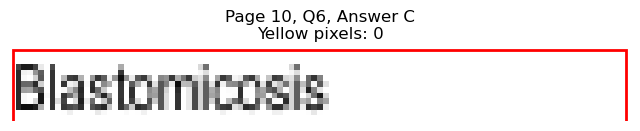

Page 10, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=421.3, y1=455.5
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 504
Page 10, Q6, D: Yellow percentage: 0.0%


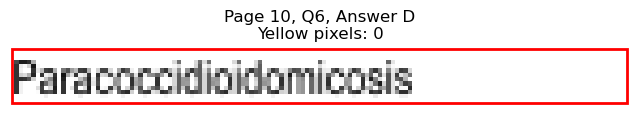


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el protozoo causante de la enfermedad...
1   Linfoma insidioso más frecuente en adultos, co...
2   Varón de 36 años, con lesión localizada en zon...
3   ¿Qué tipo de linfocitos originan el síndrome d...
4   ¿Qué lóbulos cerebrales son afectados en la en...
..                                                ...
95  Los hallazgos microscópicos, de una arteria pe...
96  De los siguientes patrones de arterioesclerosi...
97  ¿Cuál es la localización más frecuente de la h...
98  Mujer de 50 años con lesión pruriginosa, roja ...
99  Varón de 30 años, con historia de tos producti...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                          option_B  \
0                    Entamoeba histolytica               Leishmania donovani   
1              B difuso de células grandes                         Folicular   
2                            Ameloblastoma             Fibroma ameloblástico   
3                            T colaborador                      T citotóxico   
4                     Temporal y occipital              Parietal y occipital   
..                                     ...                               ...   
95               Síndrome de Churg-Strauss        Tromboangeítis obliterante   
96  Hiperplasia fibromuscular de la íntima               Arterioloesclerosis   
97                                Cerebelo                  Ganglios basales   
98                        Melanoma in situ  Enfermedad de Paget extramamaria   
99                          Histoplasmosis                     Criptococosis   

                                option_C                         option_D  
0                      Naegleria fowleri                Trypanosoma cruzi  
1                    Linfocítico pequeño                       De Burkitt  
2            Fibroodontoma ameloblástico    Tumor odontógeno adenomatoide  
3                              B memoria                         B virgen  
4                    Frontal y occipital              Parietal y temporal  
..                                   ...                              ...  
95           Polivasculitis microscópica           Enfermedad de Kawasaki  
96  Esclerosis de la media de Mönckeberg                  Ateroesclerosis  
97                         Protuberancia                   Lóbulo frontal  
98                   Hidradenoma papilar  Neoplasia vulvar intraepitelial  
99                         Blastomicosis           Paracoccidioidomicosis  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es el protozoo causante de la enfermedad...   
1   Linfoma insidioso más frecuente en adultos, co...   
2   Varón de 36 años, con lesión localizada en zon...   
3   ¿Qué tipo de linfocitos originan el síndrome d...   
4   ¿Qué lóbulos cerebrales son afectados en la en...   
..                                                ...   
95  Los hallazgos microscópicos, de una arteria pe...   
96  De los siguientes patrones de arterioesclerosi...   
97  ¿Cuál es la localización más frecuente de la h...   
98  Mujer de 50 años con lesión pruriginosa, roja ...   
99  Varón de 30 años, con historia de tos producti...   

                                  option_A                          option_B  \
0                    Entamoeba histolytica               Leishmania donovani   
1              B difuso de células grandes                         Folicular   
2                            Ameloblastoma             Fibroma ameloblástico   
3                            T colaborador                      T citotóxico   
4                     Temporal y occipital              Parietal y occipital   
..                                     ...                               ...   
95               Síndrome de Churg-Strauss        Tromboangeítis obliterante   
96  Hiperplasia fibromuscular de la íntima               Arterioloesclerosis   
97                                Cerebelo                  Ganglios basales   
98                        Melanoma in situ  Enfermedad de Paget extramamaria   
99                          Histoplasmosis                     Criptococosis   

                                option_C                         option_D  \
0                      Naegleria fowleri                Trypanosoma cruzi   
1                    Linfocítico pequeño                       De Burkitt   
2            Fibroodontoma ameloblástico    Tumor odontógeno adenomatoide   
3                              B memoria                         B virgen   
4                    Frontal y occipital              Parietal y temporal   
..                                   ...                              ...   
95           Polivasculitis microscópica           Enfermedad de Kawasaki   
96  Esclerosis de la media de Mönckeberg                  Ateroesclerosis   
97                         Protuberancia                   Lóbulo frontal   
98                   Hidradenoma papilar  Neoplasia vulvar intraepitelial   
99                         Blastomicosis           Paracoccidioidomicosis   

   correct_answer  
0               B  
1               B  
2               A  
3               A  
4               D  
..            ...  
95              B  
96              A  
97              B  
98              B  
99              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ANATOMÍA PATOLÓGICA.csv
